In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import scipy.io as io
import isunapiWS as api
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
import h5py
from scipy import ndimage
import os
import cv2
from PIL import Image

In [10]:
ordered_fixations = io.loadmat('../Datasets/iSUN/ms_training_fixations/resized_meanshift_fixations_20180220-203846.mat')
ordered_fixations = ordered_fixations['meanshift_fixations'][0]
ISUN_MAT_FILE = '../Datasets/iSUN/resized_training_20180220-141451.mat'
train = io.loadmat(ISUN_MAT_FILE) 

# Dataset study

### Amount of users per image:

In [11]:
#Afegit per mi

def users_per_image_histogram(ordered_fixations):
    users=np.empty(ordered_fixations.shape[0])
    userscount=0
    for i in range(0,ordered_fixations.shape[0]):
        users[i]=ordered_fixations[i].shape[1]
        userscount+=ordered_fixations[i].shape[1]
    #hist=np.histogram(users,bins='auto')
    plt.hist(users,bins='auto')
    plt.title("Histogram of the amount of users per image in the iSUN dataset")
    plt.show()
    return userscount

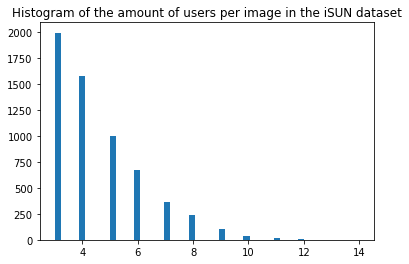

Total number of users: 27319


In [205]:
userscount=users_per_image_histogram(ordered_fixations)
print "Total number of users: " + str(userscount)

### Amount of fixations per user:

In [206]:
def fix_per_user_hist(ordered_fixations,totaluserscount):
    fix=np.empty(totaluserscount) #llargada = num total d usuaris
    usercount=0

    for m in range(0,ordered_fixations.shape[0]): # iterem totes les img
        for i in range(0,ordered_fixations[m].shape[1]): # iterem tots usr de la img
            #Posicio de fix
            fix[usercount]=ordered_fixations[m][0][i].shape[0] # Assignem
    amax=int(round(np.amax(fix)))
    plt.hist(fix,bins=range(0,amax))
    plt.title('Histogram of the amount of fixations per user in the iSUN dataset')
    plt.show()
    print "Biggest number of fixations : " + str(amax)

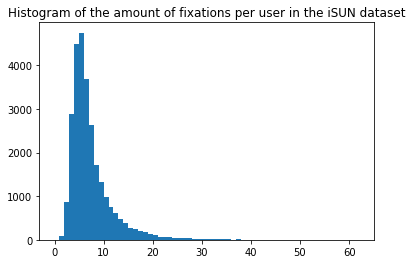

Biggest number of fixations : 63


In [207]:
fix_per_user_hist(ordered_fixations,userscount)

Looking at the number of fixations distribution we can see that many users have between 3 and 8 fixations. It is well known that the first fixations we look at use to be the most relevant ones, for that reason the first fixations should have more weight when computing the temporally weigthed saliency maps than the ones that follows. For that reason a decreasing fuction should be used for the weighting.

In [3]:
def get_ids_images_with_more_workers(ordered_fixations, n_workers):
    ids = []
    for n in range(6000):
        if ordered_fixations[n].shape[1] >= n_workers:
            ids.append(n)
    
    return ids

images_with_more_workers = get_ids_images_with_more_workers(ordered_fixations, 10)
print images_with_more_workers
print '\nNumber of images with 10 workers:',len(images_with_more_workers)
  

[285, 447, 455, 528, 549, 627, 680, 760, 873, 927, 955, 1032, 1068, 1301, 1368, 1541, 1580, 1598, 1599, 1673, 2036, 2178, 2283, 2301, 2304, 2310, 2444, 2545, 2749, 2982, 3282, 3293, 3406, 3514, 3764, 3888, 3967, 4072, 4295, 4438, 4526, 4532, 4615, 4658, 4737, 4841, 4969, 4990, 5184, 5236, 5308, 5454, 5470, 5507, 5521, 5628, 5634, 5822, 5883]

Number of images with 10 workers: 59


In [272]:
def get_ids_images_with_more_fixations(ordered_fixations, n_fix):
    ids=[]
    for m in range(0,ordered_fixations.shape[0]): # iterem totes les img
        for i in range(0,ordered_fixations[m].shape[1]): # iterem tots usr de la img
            if ordered_fixations[m][0][i].shape[0] >= n_fix : 
                ids.append(m)
    return ids

In [277]:
ids=get_ids_images_with_more_fixations(ordered_fixations , 40)
print 'Number of images with more fixations:',len(ids)
print ids

Number of images with more fixations: 41
[291, 291, 635, 1008, 1128, 1172, 1250, 1641, 1674, 1691, 2338, 2387, 2387, 2678, 2793, 2878, 3026, 3110, 3280, 3317, 3450, 3450, 3553, 3699, 3758, 3919, 3978, 4413, 4524, 4758, 4758, 4926, 4926, 4934, 4948, 5099, 5117, 5150, 5253, 5458, 5515]


# Weighting:

Weighting function:

In [44]:
# Weighting function
def weighting_function(params):
    x = np.linspace(0,1,1000)
    weights = np.exp(-params* x)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot(x,weights)
    plt.show()

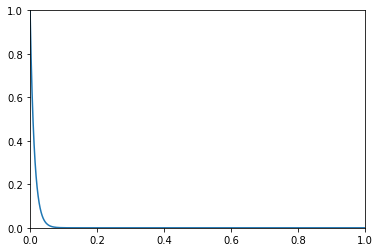

In [41]:
weighting_function(80)

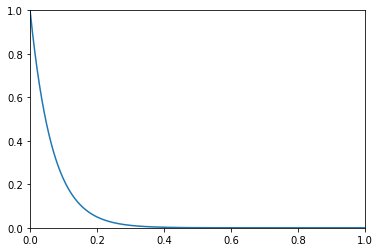

In [45]:
weighting_function(15)

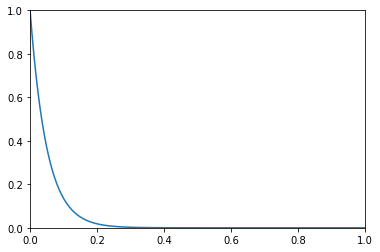

In [71]:
weighting_function(20)

### Building a Weighted Saliency Map

In [4]:
def weighted_points(points, params, weight_type):
    '''
    Recieves an array of points of shape (x,y) and returns and adds a third column (x,y,w) that
    represents the weight
    
    '''
    n_points = points.shape[0]
    
    
    if weight_type == 'exp': 
        x = np.linspace(0,1,100)
        weights = np.exp(-params * x)
        
    elif weight_type == 'linear':
        x = np.linspace(0,1,100)
        weights = np.maximum(params * x + 1, 0)
        
    elif weight_type == 'exp_asc':
        x = np.linspace(0,1,100)
        weights = np.exp(params* x)-0.9
    
    weight = weights[:n_points].reshape(n_points,1)
    
    points_with_weights = np.hstack((points, weight))

    return points_with_weights

In [5]:
def weighted_points_all_workers(image_fixations, params, weight_type='exp'):
    worker_fixations_weighted = 0
    image_fixations=image_fixations[0]
        
    for w in range(image_fixations.shape[0]):
        worker_fixations = image_fixations[w]
        w_p = weighted_points(worker_fixations, params, weight_type=weight_type)
    
        if type(worker_fixations_weighted) == int:
            worker_fixations_weighted = w_p
        else:
            worker_fixations_weighted = np.vstack((worker_fixations_weighted, w_p))
        
    return worker_fixations_weighted


In [6]:
def build_weighed_probability_map(merged_locations, size,sigma=40):
    '''
        Build weighted probability map for one worker
        
    '''
 
    #create saliency map
    sal_map = np.zeros((size[0],size[1]))

    i = 0
    for x,y,w in merged_locations:
        if x < size[1] and y < size[0] : 
            sal_map[int(y-1)][int(x-1)] = w
            i += 1

    
    sal_map = ndimage.filters.gaussian_filter(sal_map, sigma)
    prob_map = sal_map / np.sum(sal_map.flatten())
    return prob_map

Name of the test img : sun_alzyegyliegcqexz


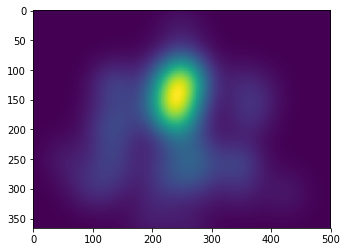

In [7]:
img_id = 927
image_fixation = ordered_fixations[img_id]
name, fixations, locations, timestamps, size = api.get_image_data(train, img_id)


print 'Name of the test img : ' + name
DATASET_PATH = '../Datasets/iSUN/'

salmap = io.loadmat(DATASET_PATH + 'saliency/'+ name +'.mat')

plt.imshow(salmap['I'])
plt.show()

Construir el saliency map i imprimir ambdos maps:

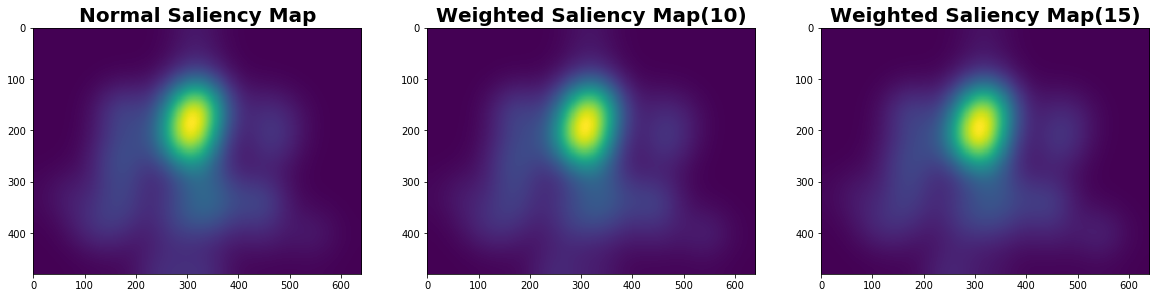

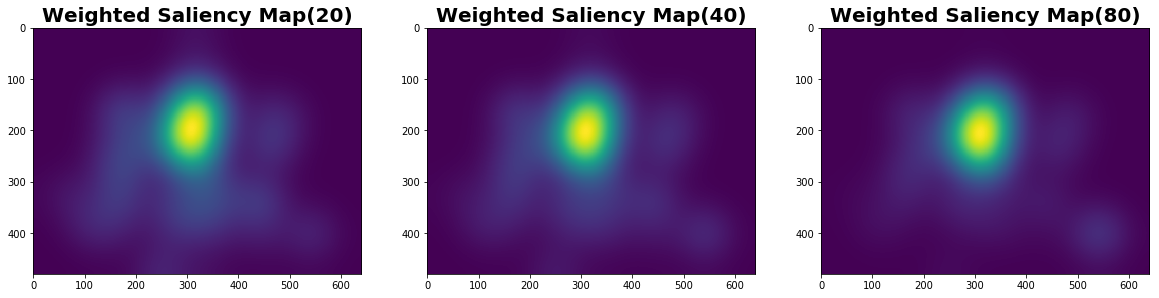

In [12]:
total_image_fixations=image_fixation[0]
# Compute maps
merged_fixations = api.merge_locations(total_image_fixations) #Unim les fixacions de tots els usuaris en un sol numpy array
prob_map = api.build_probability_map(merged_fixations, size, sigma=40)

w_fix_weighted = weighted_points_all_workers(image_fixation, 10)
w_prob_map2 = build_weighed_probability_map(w_fix_weighted, size, sigma=40)

w_fix_weighted3 = weighted_points_all_workers(image_fixation, 15)
w_prob_map3 = build_weighed_probability_map(w_fix_weighted3, size, sigma=40)

w_fix_weighted4 = weighted_points_all_workers(image_fixation, 20)
w_prob_map4 = build_weighed_probability_map(w_fix_weighted4, size, sigma=40)

w_fix_weighted5 = weighted_points_all_workers(image_fixation, 40)
w_prob_map5 = build_weighed_probability_map(w_fix_weighted5, size, sigma=40)

w_fix_weighted6 = weighted_points_all_workers(image_fixation, 80)
w_prob_map6 = build_weighed_probability_map(w_fix_weighted6, size, sigma=40)



# Plot maps

fig = plt.figure(figsize=(20,50))

subplot1 = fig.add_subplot(131)
subplot1.imshow(prob_map)
subplot1.set_title('Normal Saliency Map', fontsize=20, fontweight='bold')

subplot2 = fig.add_subplot(132)
subplot2.imshow(w_prob_map2)
subplot2.set_title('Weighted Saliency Map(10)', fontsize=20, fontweight='bold')

subplot3 = fig.add_subplot(133)
subplot3.imshow(w_prob_map3)
subplot3.set_title('Weighted Saliency Map(15)', fontsize=20, fontweight='bold')
plt.show()

fig1=plt.figure(figsize=(20,50))
subplot4 = fig1.add_subplot(131)
subplot4.imshow(w_prob_map4)
subplot4.set_title('Weighted Saliency Map(20)', fontsize=20, fontweight='bold')

subplot5 = fig1.add_subplot(132)
subplot5.imshow(w_prob_map5)
subplot5.set_title('Weighted Saliency Map(40)', fontsize=20, fontweight='bold')

subplot6 = fig1.add_subplot(133)
subplot6.imshow(w_prob_map6)
subplot6.set_title('Weighted Saliency Map(80)', fontsize=20, fontweight='bold')

plt.show()

## Store Normal Saliency Maps iSUN Dataset :

In [6]:
SALMAP_PATH = 'SM_iSUN/'

In [46]:
for img_id in range(0,ordered_fixations.shape[0]):

    image_fixation = ordered_fixations[img_id]
    name, fixations, locations, timestamps, size = api.get_image_data(train, img_id)
    size=np.array(size,dtype=np.uint32)
    if (size[0]!=480):
        size[0]=480
        size[1]=640
    salmap=np.empty((size[0],size[1]),dtype=float)
    total_image_fixations=image_fixation[0]
    #print total_image_fixations

    merged_fixations = api.merge_locations(total_image_fixations) #Unim les fixacions de tots els usuaris en un sol numpy array
    salmap = api.build_probability_map(merged_fixations, size, sigma=40)

    #print salmap
    io.savemat(SALMAP_PATH + name, {'I': salmap})
    print 'Image '+ str(img_id) + 'done!'
    
    

Image 0done!
Image 1done!
Image 2done!
Image 3done!
Image 4done!
Image 5done!
Image 6done!
Image 7done!
Image 8done!
Image 9done!
Image 10done!
Image 11done!
Image 12done!
Image 13done!
Image 14done!
Image 15done!
Image 16done!
Image 17done!
Image 18done!
Image 19done!
Image 20done!
Image 21done!
Image 22done!
Image 23done!
Image 24done!
Image 25done!
Image 26done!
Image 27done!
Image 28done!
Image 29done!
Image 30done!
Image 31done!
Image 32done!
Image 33done!
Image 34done!
Image 35done!
Image 36done!
Image 37done!
Image 38done!
Image 39done!
Image 40done!
Image 41done!
Image 42done!
Image 43done!
Image 44done!
Image 45done!
Image 46done!
Image 47done!
Image 48done!
Image 49done!
Image 50done!
Image 51done!
Image 52done!
Image 53done!
Image 54done!
Image 55done!
Image 56done!
Image 57done!
Image 58done!
Image 59done!
Image 60done!
Image 61done!
Image 62done!
Image 63done!
Image 64done!
Image 65done!
Image 66done!
Image 67done!
Image 68done!
Image 69done!
Image 70done!
Image 71done!
Im

Image 555done!
Image 556done!
Image 557done!
Image 558done!
Image 559done!
Image 560done!
Image 561done!
Image 562done!
Image 563done!
Image 564done!
Image 565done!
Image 566done!
Image 567done!
Image 568done!
Image 569done!
Image 570done!
Image 571done!
Image 572done!
Image 573done!
Image 574done!
Image 575done!
Image 576done!
Image 577done!
Image 578done!
Image 579done!
Image 580done!
Image 581done!
Image 582done!
Image 583done!
Image 584done!
Image 585done!
Image 586done!
Image 587done!
Image 588done!
Image 589done!
Image 590done!
Image 591done!
Image 592done!
Image 593done!
Image 594done!
Image 595done!
Image 596done!
Image 597done!
Image 598done!
Image 599done!
Image 600done!
Image 601done!
Image 602done!
Image 603done!
Image 604done!
Image 605done!
Image 606done!
Image 607done!
Image 608done!
Image 609done!
Image 610done!
Image 611done!
Image 612done!
Image 613done!
Image 614done!
Image 615done!
Image 616done!
Image 617done!
Image 618done!
Image 619done!
Image 620done!
Image 621d

Image 1097done!
Image 1098done!
Image 1099done!
Image 1100done!
Image 1101done!
Image 1102done!
Image 1103done!
Image 1104done!
Image 1105done!
Image 1106done!
Image 1107done!
Image 1108done!
Image 1109done!
Image 1110done!
Image 1111done!
Image 1112done!
Image 1113done!
Image 1114done!
Image 1115done!
Image 1116done!
Image 1117done!
Image 1118done!
Image 1119done!
Image 1120done!
Image 1121done!
Image 1122done!
Image 1123done!
Image 1124done!
Image 1125done!
Image 1126done!
Image 1127done!
Image 1128done!
Image 1129done!
Image 1130done!
Image 1131done!
Image 1132done!
Image 1133done!
Image 1134done!
Image 1135done!
Image 1136done!
Image 1137done!
Image 1138done!
Image 1139done!
Image 1140done!
Image 1141done!
Image 1142done!
Image 1143done!
Image 1144done!
Image 1145done!
Image 1146done!
Image 1147done!
Image 1148done!
Image 1149done!
Image 1150done!
Image 1151done!
Image 1152done!
Image 1153done!
Image 1154done!
Image 1155done!
Image 1156done!
Image 1157done!
Image 1158done!
Image 11

Image 1612done!
Image 1613done!
Image 1614done!
Image 1615done!
Image 1616done!
Image 1617done!
Image 1618done!
Image 1619done!
Image 1620done!
Image 1621done!
Image 1622done!
Image 1623done!
Image 1624done!
Image 1625done!
Image 1626done!
Image 1627done!
Image 1628done!
Image 1629done!
Image 1630done!
Image 1631done!
Image 1632done!
Image 1633done!
Image 1634done!
Image 1635done!
Image 1636done!
Image 1637done!
Image 1638done!
Image 1639done!
Image 1640done!
Image 1641done!
Image 1642done!
Image 1643done!
Image 1644done!
Image 1645done!
Image 1646done!
Image 1647done!
Image 1648done!
Image 1649done!
Image 1650done!
Image 1651done!
Image 1652done!
Image 1653done!
Image 1654done!
Image 1655done!
Image 1656done!
Image 1657done!
Image 1658done!
Image 1659done!
Image 1660done!
Image 1661done!
Image 1662done!
Image 1663done!
Image 1664done!
Image 1665done!
Image 1666done!
Image 1667done!
Image 1668done!
Image 1669done!
Image 1670done!
Image 1671done!
Image 1672done!
Image 1673done!
Image 16

Image 2127done!
Image 2128done!
Image 2129done!
Image 2130done!
Image 2131done!
Image 2132done!
Image 2133done!
Image 2134done!
Image 2135done!
Image 2136done!
Image 2137done!
Image 2138done!
Image 2139done!
Image 2140done!
Image 2141done!
Image 2142done!
Image 2143done!
Image 2144done!
Image 2145done!
Image 2146done!
Image 2147done!
Image 2148done!
Image 2149done!
Image 2150done!
Image 2151done!
Image 2152done!
Image 2153done!
Image 2154done!
Image 2155done!
Image 2156done!
Image 2157done!
Image 2158done!
Image 2159done!
Image 2160done!
Image 2161done!
Image 2162done!
Image 2163done!
Image 2164done!
Image 2165done!
Image 2166done!
Image 2167done!
Image 2168done!
Image 2169done!
Image 2170done!
Image 2171done!
Image 2172done!
Image 2173done!
Image 2174done!
Image 2175done!
Image 2176done!
Image 2177done!
Image 2178done!
Image 2179done!
Image 2180done!
Image 2181done!
Image 2182done!
Image 2183done!
Image 2184done!
Image 2185done!
Image 2186done!
Image 2187done!
Image 2188done!
Image 21

Image 2640done!
Image 2641done!
Image 2642done!
Image 2643done!
Image 2644done!
Image 2645done!
Image 2646done!
Image 2647done!
Image 2648done!
Image 2649done!
Image 2650done!
Image 2651done!
Image 2652done!
Image 2653done!
Image 2654done!
Image 2655done!
Image 2656done!
Image 2657done!
Image 2658done!
Image 2659done!
Image 2660done!
Image 2661done!
Image 2662done!
Image 2663done!
Image 2664done!
Image 2665done!
Image 2666done!
Image 2667done!
Image 2668done!
Image 2669done!
Image 2670done!
Image 2671done!
Image 2672done!
Image 2673done!
Image 2674done!
Image 2675done!
Image 2676done!
Image 2677done!
Image 2678done!
Image 2679done!
Image 2680done!
Image 2681done!
Image 2682done!
Image 2683done!
Image 2684done!
Image 2685done!
Image 2686done!
Image 2687done!
Image 2688done!
Image 2689done!
Image 2690done!
Image 2691done!
Image 2692done!
Image 2693done!
Image 2694done!
Image 2695done!
Image 2696done!
Image 2697done!
Image 2698done!
Image 2699done!
Image 2700done!
Image 2701done!
Image 27

Image 3153done!
Image 3154done!
Image 3155done!
Image 3156done!
Image 3157done!
Image 3158done!
Image 3159done!
Image 3160done!
Image 3161done!
Image 3162done!
Image 3163done!
Image 3164done!
Image 3165done!
Image 3166done!
Image 3167done!
Image 3168done!
Image 3169done!
Image 3170done!
Image 3171done!
Image 3172done!
Image 3173done!
Image 3174done!
Image 3175done!
Image 3176done!
Image 3177done!
Image 3178done!
Image 3179done!
Image 3180done!
Image 3181done!
Image 3182done!
Image 3183done!
Image 3184done!
Image 3185done!
Image 3186done!
Image 3187done!
Image 3188done!
Image 3189done!
Image 3190done!
Image 3191done!
Image 3192done!
Image 3193done!
Image 3194done!
Image 3195done!
Image 3196done!
Image 3197done!
Image 3198done!
Image 3199done!
Image 3200done!
Image 3201done!
Image 3202done!
Image 3203done!
Image 3204done!
Image 3205done!
Image 3206done!
Image 3207done!
Image 3208done!
Image 3209done!
Image 3210done!
Image 3211done!
Image 3212done!
Image 3213done!
Image 3214done!
Image 32

Image 3667done!
Image 3668done!
Image 3669done!
Image 3670done!
Image 3671done!
Image 3672done!
Image 3673done!
Image 3674done!
Image 3675done!
Image 3676done!
Image 3677done!
Image 3678done!
Image 3679done!
Image 3680done!
Image 3681done!
Image 3682done!
Image 3683done!
Image 3684done!
Image 3685done!
Image 3686done!
Image 3687done!
Image 3688done!
Image 3689done!
Image 3690done!
Image 3691done!
Image 3692done!
Image 3693done!
Image 3694done!
Image 3695done!
Image 3696done!
Image 3697done!
Image 3698done!
Image 3699done!
Image 3700done!
Image 3701done!
Image 3702done!
Image 3703done!
Image 3704done!
Image 3705done!
Image 3706done!
Image 3707done!
Image 3708done!
Image 3709done!
Image 3710done!
Image 3711done!
Image 3712done!
Image 3713done!
Image 3714done!
Image 3715done!
Image 3716done!
Image 3717done!
Image 3718done!
Image 3719done!
Image 3720done!
Image 3721done!
Image 3722done!
Image 3723done!
Image 3724done!
Image 3725done!
Image 3726done!
Image 3727done!
Image 3728done!
Image 37

Image 4181done!
Image 4182done!
Image 4183done!
Image 4184done!
Image 4185done!
Image 4186done!
Image 4187done!
Image 4188done!
Image 4189done!
Image 4190done!
Image 4191done!
Image 4192done!
Image 4193done!
Image 4194done!
Image 4195done!
Image 4196done!
Image 4197done!
Image 4198done!
Image 4199done!
Image 4200done!
Image 4201done!
Image 4202done!
Image 4203done!
Image 4204done!
Image 4205done!
Image 4206done!
Image 4207done!
Image 4208done!
Image 4209done!
Image 4210done!
Image 4211done!
Image 4212done!
Image 4213done!
Image 4214done!
Image 4215done!
Image 4216done!
Image 4217done!
Image 4218done!
Image 4219done!
Image 4220done!
Image 4221done!
Image 4222done!
Image 4223done!
Image 4224done!
Image 4225done!
Image 4226done!
Image 4227done!
Image 4228done!
Image 4229done!
Image 4230done!
Image 4231done!
Image 4232done!
Image 4233done!
Image 4234done!
Image 4235done!
Image 4236done!
Image 4237done!
Image 4238done!
Image 4239done!
Image 4240done!
Image 4241done!
Image 4242done!
Image 42

Image 4694done!
Image 4695done!
Image 4696done!
Image 4697done!
Image 4698done!
Image 4699done!
Image 4700done!
Image 4701done!
Image 4702done!
Image 4703done!
Image 4704done!
Image 4705done!
Image 4706done!
Image 4707done!
Image 4708done!
Image 4709done!
Image 4710done!
Image 4711done!
Image 4712done!
Image 4713done!
Image 4714done!
Image 4715done!
Image 4716done!
Image 4717done!
Image 4718done!
Image 4719done!
Image 4720done!
Image 4721done!
Image 4722done!
Image 4723done!
Image 4724done!
Image 4725done!
Image 4726done!
Image 4727done!
Image 4728done!
Image 4729done!
Image 4730done!
Image 4731done!
Image 4732done!
Image 4733done!
Image 4734done!
Image 4735done!
Image 4736done!
Image 4737done!
Image 4738done!
Image 4739done!
Image 4740done!
Image 4741done!
Image 4742done!
Image 4743done!
Image 4744done!
Image 4745done!
Image 4746done!
Image 4747done!
Image 4748done!
Image 4749done!
Image 4750done!
Image 4751done!
Image 4752done!
Image 4753done!
Image 4754done!
Image 4755done!
Image 47

Image 5208done!
Image 5209done!
Image 5210done!
Image 5211done!
Image 5212done!
Image 5213done!
Image 5214done!
Image 5215done!
Image 5216done!
Image 5217done!
Image 5218done!
Image 5219done!
Image 5220done!
Image 5221done!
Image 5222done!
Image 5223done!
Image 5224done!
Image 5225done!
Image 5226done!
Image 5227done!
Image 5228done!
Image 5229done!
Image 5230done!
Image 5231done!
Image 5232done!
Image 5233done!
Image 5234done!
Image 5235done!
Image 5236done!
Image 5237done!
Image 5238done!
Image 5239done!
Image 5240done!
Image 5241done!
Image 5242done!
Image 5243done!
Image 5244done!
Image 5245done!
Image 5246done!
Image 5247done!
Image 5248done!
Image 5249done!
Image 5250done!
Image 5251done!
Image 5252done!
Image 5253done!
Image 5254done!
Image 5255done!
Image 5256done!
Image 5257done!
Image 5258done!
Image 5259done!
Image 5260done!
Image 5261done!
Image 5262done!
Image 5263done!
Image 5264done!
Image 5265done!
Image 5266done!
Image 5267done!
Image 5268done!
Image 5269done!
Image 52

Image 5723done!
Image 5724done!
Image 5725done!
Image 5726done!
Image 5727done!
Image 5728done!
Image 5729done!
Image 5730done!
Image 5731done!
Image 5732done!
Image 5733done!
Image 5734done!
Image 5735done!
Image 5736done!
Image 5737done!
Image 5738done!
Image 5739done!
Image 5740done!
Image 5741done!
Image 5742done!
Image 5743done!
Image 5744done!
Image 5745done!
Image 5746done!
Image 5747done!
Image 5748done!
Image 5749done!
Image 5750done!
Image 5751done!
Image 5752done!
Image 5753done!
Image 5754done!
Image 5755done!
Image 5756done!
Image 5757done!
Image 5758done!
Image 5759done!
Image 5760done!
Image 5761done!
Image 5762done!
Image 5763done!
Image 5764done!
Image 5765done!
Image 5766done!
Image 5767done!
Image 5768done!
Image 5769done!
Image 5770done!
Image 5771done!
Image 5772done!
Image 5773done!
Image 5774done!
Image 5775done!
Image 5776done!
Image 5777done!
Image 5778done!
Image 5779done!
Image 5780done!
Image 5781done!
Image 5782done!
Image 5783done!
Image 5784done!
Image 57

## Store Weighted Saliency Maps iSUN Dataset:

In [50]:
wSALMAP_PATH='wSM_iSUN/'

In [51]:
for img_id in range(0,ordered_fixations.shape[0]):

    image_fixation = ordered_fixations[img_id]
    name, fixations, locations, timestamps, size = api.get_image_data(train, img_id)
    size=np.array(size,dtype=np.uint32)
    if (size[0]!=480):
        size[0]=480
        size[1]=640
    salmap=np.empty((size[0],size[1]),dtype=float)
    w_fix_weighted4 = weighted_points_all_workers(image_fixation, 20)
    wsalmap = build_weighed_probability_map(w_fix_weighted4, size, sigma=40)
    
    #print salmap
    io.savemat(wSALMAP_PATH + name, {'I': wsalmap})
    print 'Image '+ str(img_id) + 'done!'
    
    

Image 0done!
Image 1done!
Image 2done!
Image 3done!
Image 4done!
Image 5done!
Image 6done!
Image 7done!
Image 8done!
Image 9done!
Image 10done!
Image 11done!
Image 12done!
Image 13done!
Image 14done!
Image 15done!
Image 16done!
Image 17done!
Image 18done!
Image 19done!
Image 20done!
Image 21done!
Image 22done!
Image 23done!
Image 24done!
Image 25done!
Image 26done!
Image 27done!
Image 28done!
Image 29done!
Image 30done!
Image 31done!
Image 32done!
Image 33done!
Image 34done!
Image 35done!
Image 36done!
Image 37done!
Image 38done!
Image 39done!
Image 40done!
Image 41done!
Image 42done!
Image 43done!
Image 44done!
Image 45done!
Image 46done!
Image 47done!
Image 48done!
Image 49done!
Image 50done!
Image 51done!
Image 52done!
Image 53done!
Image 54done!
Image 55done!
Image 56done!
Image 57done!
Image 58done!
Image 59done!
Image 60done!
Image 61done!
Image 62done!
Image 63done!
Image 64done!
Image 65done!
Image 66done!
Image 67done!
Image 68done!
Image 69done!
Image 70done!
Image 71done!
Im

Image 556done!
Image 557done!
Image 558done!
Image 559done!
Image 560done!
Image 561done!
Image 562done!
Image 563done!
Image 564done!
Image 565done!
Image 566done!
Image 567done!
Image 568done!
Image 569done!
Image 570done!
Image 571done!
Image 572done!
Image 573done!
Image 574done!
Image 575done!
Image 576done!
Image 577done!
Image 578done!
Image 579done!
Image 580done!
Image 581done!
Image 582done!
Image 583done!
Image 584done!
Image 585done!
Image 586done!
Image 587done!
Image 588done!
Image 589done!
Image 590done!
Image 591done!
Image 592done!
Image 593done!
Image 594done!
Image 595done!
Image 596done!
Image 597done!
Image 598done!
Image 599done!
Image 600done!
Image 601done!
Image 602done!
Image 603done!
Image 604done!
Image 605done!
Image 606done!
Image 607done!
Image 608done!
Image 609done!
Image 610done!
Image 611done!
Image 612done!
Image 613done!
Image 614done!
Image 615done!
Image 616done!
Image 617done!
Image 618done!
Image 619done!
Image 620done!
Image 621done!
Image 622d

Image 1098done!
Image 1099done!
Image 1100done!
Image 1101done!
Image 1102done!
Image 1103done!
Image 1104done!
Image 1105done!
Image 1106done!
Image 1107done!
Image 1108done!
Image 1109done!
Image 1110done!
Image 1111done!
Image 1112done!
Image 1113done!
Image 1114done!
Image 1115done!
Image 1116done!
Image 1117done!
Image 1118done!
Image 1119done!
Image 1120done!
Image 1121done!
Image 1122done!
Image 1123done!
Image 1124done!
Image 1125done!
Image 1126done!
Image 1127done!
Image 1128done!
Image 1129done!
Image 1130done!
Image 1131done!
Image 1132done!
Image 1133done!
Image 1134done!
Image 1135done!
Image 1136done!
Image 1137done!
Image 1138done!
Image 1139done!
Image 1140done!
Image 1141done!
Image 1142done!
Image 1143done!
Image 1144done!
Image 1145done!
Image 1146done!
Image 1147done!
Image 1148done!
Image 1149done!
Image 1150done!
Image 1151done!
Image 1152done!
Image 1153done!
Image 1154done!
Image 1155done!
Image 1156done!
Image 1157done!
Image 1158done!
Image 1159done!
Image 11

Image 1611done!
Image 1612done!
Image 1613done!
Image 1614done!
Image 1615done!
Image 1616done!
Image 1617done!
Image 1618done!
Image 1619done!
Image 1620done!
Image 1621done!
Image 1622done!
Image 1623done!
Image 1624done!
Image 1625done!
Image 1626done!
Image 1627done!
Image 1628done!
Image 1629done!
Image 1630done!
Image 1631done!
Image 1632done!
Image 1633done!
Image 1634done!
Image 1635done!
Image 1636done!
Image 1637done!
Image 1638done!
Image 1639done!
Image 1640done!
Image 1641done!
Image 1642done!
Image 1643done!
Image 1644done!
Image 1645done!
Image 1646done!
Image 1647done!
Image 1648done!
Image 1649done!
Image 1650done!
Image 1651done!
Image 1652done!
Image 1653done!
Image 1654done!
Image 1655done!
Image 1656done!
Image 1657done!
Image 1658done!
Image 1659done!
Image 1660done!
Image 1661done!
Image 1662done!
Image 1663done!
Image 1664done!
Image 1665done!
Image 1666done!
Image 1667done!
Image 1668done!
Image 1669done!
Image 1670done!
Image 1671done!
Image 1672done!
Image 16

Image 2124done!
Image 2125done!
Image 2126done!
Image 2127done!
Image 2128done!
Image 2129done!
Image 2130done!
Image 2131done!
Image 2132done!
Image 2133done!
Image 2134done!
Image 2135done!
Image 2136done!
Image 2137done!
Image 2138done!
Image 2139done!
Image 2140done!
Image 2141done!
Image 2142done!
Image 2143done!
Image 2144done!
Image 2145done!
Image 2146done!
Image 2147done!
Image 2148done!
Image 2149done!
Image 2150done!
Image 2151done!
Image 2152done!
Image 2153done!
Image 2154done!
Image 2155done!
Image 2156done!
Image 2157done!
Image 2158done!
Image 2159done!
Image 2160done!
Image 2161done!
Image 2162done!
Image 2163done!
Image 2164done!
Image 2165done!
Image 2166done!
Image 2167done!
Image 2168done!
Image 2169done!
Image 2170done!
Image 2171done!
Image 2172done!
Image 2173done!
Image 2174done!
Image 2175done!
Image 2176done!
Image 2177done!
Image 2178done!
Image 2179done!
Image 2180done!
Image 2181done!
Image 2182done!
Image 2183done!
Image 2184done!
Image 2185done!
Image 21

Image 2637done!
Image 2638done!
Image 2639done!
Image 2640done!
Image 2641done!
Image 2642done!
Image 2643done!
Image 2644done!
Image 2645done!
Image 2646done!
Image 2647done!
Image 2648done!
Image 2649done!
Image 2650done!
Image 2651done!
Image 2652done!
Image 2653done!
Image 2654done!
Image 2655done!
Image 2656done!
Image 2657done!
Image 2658done!
Image 2659done!
Image 2660done!
Image 2661done!
Image 2662done!
Image 2663done!
Image 2664done!
Image 2665done!
Image 2666done!
Image 2667done!
Image 2668done!
Image 2669done!
Image 2670done!
Image 2671done!
Image 2672done!
Image 2673done!
Image 2674done!
Image 2675done!
Image 2676done!
Image 2677done!
Image 2678done!
Image 2679done!
Image 2680done!
Image 2681done!
Image 2682done!
Image 2683done!
Image 2684done!
Image 2685done!
Image 2686done!
Image 2687done!
Image 2688done!
Image 2689done!
Image 2690done!
Image 2691done!
Image 2692done!
Image 2693done!
Image 2694done!
Image 2695done!
Image 2696done!
Image 2697done!
Image 2698done!
Image 26

Image 3152done!
Image 3153done!
Image 3154done!
Image 3155done!
Image 3156done!
Image 3157done!
Image 3158done!
Image 3159done!
Image 3160done!
Image 3161done!
Image 3162done!
Image 3163done!
Image 3164done!
Image 3165done!
Image 3166done!
Image 3167done!
Image 3168done!
Image 3169done!
Image 3170done!
Image 3171done!
Image 3172done!
Image 3173done!
Image 3174done!
Image 3175done!
Image 3176done!
Image 3177done!
Image 3178done!
Image 3179done!
Image 3180done!
Image 3181done!
Image 3182done!
Image 3183done!
Image 3184done!
Image 3185done!
Image 3186done!
Image 3187done!
Image 3188done!
Image 3189done!
Image 3190done!
Image 3191done!
Image 3192done!
Image 3193done!
Image 3194done!
Image 3195done!
Image 3196done!
Image 3197done!
Image 3198done!
Image 3199done!
Image 3200done!
Image 3201done!
Image 3202done!
Image 3203done!
Image 3204done!
Image 3205done!
Image 3206done!
Image 3207done!
Image 3208done!
Image 3209done!
Image 3210done!
Image 3211done!
Image 3212done!
Image 3213done!
Image 32

Image 3666done!
Image 3667done!
Image 3668done!
Image 3669done!
Image 3670done!
Image 3671done!
Image 3672done!
Image 3673done!
Image 3674done!
Image 3675done!
Image 3676done!
Image 3677done!
Image 3678done!
Image 3679done!
Image 3680done!
Image 3681done!
Image 3682done!
Image 3683done!
Image 3684done!
Image 3685done!
Image 3686done!
Image 3687done!
Image 3688done!
Image 3689done!
Image 3690done!
Image 3691done!
Image 3692done!
Image 3693done!
Image 3694done!
Image 3695done!
Image 3696done!
Image 3697done!
Image 3698done!
Image 3699done!
Image 3700done!
Image 3701done!
Image 3702done!
Image 3703done!
Image 3704done!
Image 3705done!
Image 3706done!
Image 3707done!
Image 3708done!
Image 3709done!
Image 3710done!
Image 3711done!
Image 3712done!
Image 3713done!
Image 3714done!
Image 3715done!
Image 3716done!
Image 3717done!
Image 3718done!
Image 3719done!
Image 3720done!
Image 3721done!
Image 3722done!
Image 3723done!
Image 3724done!
Image 3725done!
Image 3726done!
Image 3727done!
Image 37

Image 4180done!
Image 4181done!
Image 4182done!
Image 4183done!
Image 4184done!
Image 4185done!
Image 4186done!
Image 4187done!
Image 4188done!
Image 4189done!
Image 4190done!
Image 4191done!
Image 4192done!
Image 4193done!
Image 4194done!
Image 4195done!
Image 4196done!
Image 4197done!
Image 4198done!
Image 4199done!
Image 4200done!
Image 4201done!
Image 4202done!
Image 4203done!
Image 4204done!
Image 4205done!
Image 4206done!
Image 4207done!
Image 4208done!
Image 4209done!
Image 4210done!
Image 4211done!
Image 4212done!
Image 4213done!
Image 4214done!
Image 4215done!
Image 4216done!
Image 4217done!
Image 4218done!
Image 4219done!
Image 4220done!
Image 4221done!
Image 4222done!
Image 4223done!
Image 4224done!
Image 4225done!
Image 4226done!
Image 4227done!
Image 4228done!
Image 4229done!
Image 4230done!
Image 4231done!
Image 4232done!
Image 4233done!
Image 4234done!
Image 4235done!
Image 4236done!
Image 4237done!
Image 4238done!
Image 4239done!
Image 4240done!
Image 4241done!
Image 42

Image 4693done!
Image 4694done!
Image 4695done!
Image 4696done!
Image 4697done!
Image 4698done!
Image 4699done!
Image 4700done!
Image 4701done!
Image 4702done!
Image 4703done!
Image 4704done!
Image 4705done!
Image 4706done!
Image 4707done!
Image 4708done!
Image 4709done!
Image 4710done!
Image 4711done!
Image 4712done!
Image 4713done!
Image 4714done!
Image 4715done!
Image 4716done!
Image 4717done!
Image 4718done!
Image 4719done!
Image 4720done!
Image 4721done!
Image 4722done!
Image 4723done!
Image 4724done!
Image 4725done!
Image 4726done!
Image 4727done!
Image 4728done!
Image 4729done!
Image 4730done!
Image 4731done!
Image 4732done!
Image 4733done!
Image 4734done!
Image 4735done!
Image 4736done!
Image 4737done!
Image 4738done!
Image 4739done!
Image 4740done!
Image 4741done!
Image 4742done!
Image 4743done!
Image 4744done!
Image 4745done!
Image 4746done!
Image 4747done!
Image 4748done!
Image 4749done!
Image 4750done!
Image 4751done!
Image 4752done!
Image 4753done!
Image 4754done!
Image 47

Image 5207done!
Image 5208done!
Image 5209done!
Image 5210done!
Image 5211done!
Image 5212done!
Image 5213done!
Image 5214done!
Image 5215done!
Image 5216done!
Image 5217done!
Image 5218done!
Image 5219done!
Image 5220done!
Image 5221done!
Image 5222done!
Image 5223done!
Image 5224done!
Image 5225done!
Image 5226done!
Image 5227done!
Image 5228done!
Image 5229done!
Image 5230done!
Image 5231done!
Image 5232done!
Image 5233done!
Image 5234done!
Image 5235done!
Image 5236done!
Image 5237done!
Image 5238done!
Image 5239done!
Image 5240done!
Image 5241done!
Image 5242done!
Image 5243done!
Image 5244done!
Image 5245done!
Image 5246done!
Image 5247done!
Image 5248done!
Image 5249done!
Image 5250done!
Image 5251done!
Image 5252done!
Image 5253done!
Image 5254done!
Image 5255done!
Image 5256done!
Image 5257done!
Image 5258done!
Image 5259done!
Image 5260done!
Image 5261done!
Image 5262done!
Image 5263done!
Image 5264done!
Image 5265done!
Image 5266done!
Image 5267done!
Image 5268done!
Image 52

Image 5720done!
Image 5721done!
Image 5722done!
Image 5723done!
Image 5724done!
Image 5725done!
Image 5726done!
Image 5727done!
Image 5728done!
Image 5729done!
Image 5730done!
Image 5731done!
Image 5732done!
Image 5733done!
Image 5734done!
Image 5735done!
Image 5736done!
Image 5737done!
Image 5738done!
Image 5739done!
Image 5740done!
Image 5741done!
Image 5742done!
Image 5743done!
Image 5744done!
Image 5745done!
Image 5746done!
Image 5747done!
Image 5748done!
Image 5749done!
Image 5750done!
Image 5751done!
Image 5752done!
Image 5753done!
Image 5754done!
Image 5755done!
Image 5756done!
Image 5757done!
Image 5758done!
Image 5759done!
Image 5760done!
Image 5761done!
Image 5762done!
Image 5763done!
Image 5764done!
Image 5765done!
Image 5766done!
Image 5767done!
Image 5768done!
Image 5769done!
Image 5770done!
Image 5771done!
Image 5772done!
Image 5773done!
Image 5774done!
Image 5775done!
Image 5776done!
Image 5777done!
Image 5778done!
Image 5779done!
Image 5780done!
Image 5781done!
Image 57

## Normalize MLNet predicted Saliency Maps

In [139]:
Pred_PATH ='../MLNet/iSUN_preds/'
Norm_Preds_PATH ='../MLNet/iSUN_normalized_preds/'
images = [Pred_PATH + f for f in os.listdir(Pred_PATH) if f.endswith('.jpg')]

In [149]:
for i, path in enumerate(images):
    filename = os.path.basename(path).split(os.extsep)[0]
    image = cv2.imread(path)  # uint8 image
    prob = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    normsalmap=prob/float(np.sum(prob.flatten()))

    io.savemat(Norm_Preds_PATH + filename, {'SI': normsalmap})
    print 'SM '+ str(i) + ' Normalized!'

SM 0 Normalized!
SM 1 Normalized!
SM 2 Normalized!
SM 3 Normalized!
SM 4 Normalized!
SM 5 Normalized!
SM 6 Normalized!
SM 7 Normalized!
SM 8 Normalized!
SM 9 Normalized!
SM 10 Normalized!
SM 11 Normalized!
SM 12 Normalized!
SM 13 Normalized!
SM 14 Normalized!
SM 15 Normalized!
SM 16 Normalized!
SM 17 Normalized!
SM 18 Normalized!
SM 19 Normalized!
SM 20 Normalized!
SM 21 Normalized!
SM 22 Normalized!
SM 23 Normalized!
SM 24 Normalized!
SM 25 Normalized!
SM 26 Normalized!
SM 27 Normalized!
SM 28 Normalized!
SM 29 Normalized!
SM 30 Normalized!
SM 31 Normalized!
SM 32 Normalized!
SM 33 Normalized!
SM 34 Normalized!
SM 35 Normalized!
SM 36 Normalized!
SM 37 Normalized!
SM 38 Normalized!
SM 39 Normalized!
SM 40 Normalized!
SM 41 Normalized!
SM 42 Normalized!
SM 43 Normalized!
SM 44 Normalized!
SM 45 Normalized!
SM 46 Normalized!
SM 47 Normalized!
SM 48 Normalized!
SM 49 Normalized!
SM 50 Normalized!
SM 51 Normalized!
SM 52 Normalized!
SM 53 Normalized!
SM 54 Normalized!
SM 55 Normalized!
SM

SM 437 Normalized!
SM 438 Normalized!
SM 439 Normalized!
SM 440 Normalized!
SM 441 Normalized!
SM 442 Normalized!
SM 443 Normalized!
SM 444 Normalized!
SM 445 Normalized!
SM 446 Normalized!
SM 447 Normalized!
SM 448 Normalized!
SM 449 Normalized!
SM 450 Normalized!
SM 451 Normalized!
SM 452 Normalized!
SM 453 Normalized!
SM 454 Normalized!
SM 455 Normalized!
SM 456 Normalized!
SM 457 Normalized!
SM 458 Normalized!
SM 459 Normalized!
SM 460 Normalized!
SM 461 Normalized!
SM 462 Normalized!
SM 463 Normalized!
SM 464 Normalized!
SM 465 Normalized!
SM 466 Normalized!
SM 467 Normalized!
SM 468 Normalized!
SM 469 Normalized!
SM 470 Normalized!
SM 471 Normalized!
SM 472 Normalized!
SM 473 Normalized!
SM 474 Normalized!
SM 475 Normalized!
SM 476 Normalized!
SM 477 Normalized!
SM 478 Normalized!
SM 479 Normalized!
SM 480 Normalized!
SM 481 Normalized!
SM 482 Normalized!
SM 483 Normalized!
SM 484 Normalized!
SM 485 Normalized!
SM 486 Normalized!
SM 487 Normalized!
SM 488 Normalized!
SM 489 Norma

SM 874 Normalized!
SM 875 Normalized!
SM 876 Normalized!
SM 877 Normalized!
SM 878 Normalized!
SM 879 Normalized!
SM 880 Normalized!
SM 881 Normalized!
SM 882 Normalized!
SM 883 Normalized!
SM 884 Normalized!
SM 885 Normalized!
SM 886 Normalized!
SM 887 Normalized!
SM 888 Normalized!
SM 889 Normalized!
SM 890 Normalized!
SM 891 Normalized!
SM 892 Normalized!
SM 893 Normalized!
SM 894 Normalized!
SM 895 Normalized!
SM 896 Normalized!
SM 897 Normalized!
SM 898 Normalized!
SM 899 Normalized!
SM 900 Normalized!
SM 901 Normalized!
SM 902 Normalized!
SM 903 Normalized!
SM 904 Normalized!
SM 905 Normalized!
SM 906 Normalized!
SM 907 Normalized!
SM 908 Normalized!
SM 909 Normalized!
SM 910 Normalized!
SM 911 Normalized!
SM 912 Normalized!
SM 913 Normalized!
SM 914 Normalized!
SM 915 Normalized!
SM 916 Normalized!
SM 917 Normalized!
SM 918 Normalized!
SM 919 Normalized!
SM 920 Normalized!
SM 921 Normalized!
SM 922 Normalized!
SM 923 Normalized!
SM 924 Normalized!
SM 925 Normalized!
SM 926 Norma

SM 1291 Normalized!
SM 1292 Normalized!
SM 1293 Normalized!
SM 1294 Normalized!
SM 1295 Normalized!
SM 1296 Normalized!
SM 1297 Normalized!
SM 1298 Normalized!
SM 1299 Normalized!
SM 1300 Normalized!
SM 1301 Normalized!
SM 1302 Normalized!
SM 1303 Normalized!
SM 1304 Normalized!
SM 1305 Normalized!
SM 1306 Normalized!
SM 1307 Normalized!
SM 1308 Normalized!
SM 1309 Normalized!
SM 1310 Normalized!
SM 1311 Normalized!
SM 1312 Normalized!
SM 1313 Normalized!
SM 1314 Normalized!
SM 1315 Normalized!
SM 1316 Normalized!
SM 1317 Normalized!
SM 1318 Normalized!
SM 1319 Normalized!
SM 1320 Normalized!
SM 1321 Normalized!
SM 1322 Normalized!
SM 1323 Normalized!
SM 1324 Normalized!
SM 1325 Normalized!
SM 1326 Normalized!
SM 1327 Normalized!
SM 1328 Normalized!
SM 1329 Normalized!
SM 1330 Normalized!
SM 1331 Normalized!
SM 1332 Normalized!
SM 1333 Normalized!
SM 1334 Normalized!
SM 1335 Normalized!
SM 1336 Normalized!
SM 1337 Normalized!
SM 1338 Normalized!
SM 1339 Normalized!
SM 1340 Normalized!


SM 1704 Normalized!
SM 1705 Normalized!
SM 1706 Normalized!
SM 1707 Normalized!
SM 1708 Normalized!
SM 1709 Normalized!
SM 1710 Normalized!
SM 1711 Normalized!
SM 1712 Normalized!
SM 1713 Normalized!
SM 1714 Normalized!
SM 1715 Normalized!
SM 1716 Normalized!
SM 1717 Normalized!
SM 1718 Normalized!
SM 1719 Normalized!
SM 1720 Normalized!
SM 1721 Normalized!
SM 1722 Normalized!
SM 1723 Normalized!
SM 1724 Normalized!
SM 1725 Normalized!
SM 1726 Normalized!
SM 1727 Normalized!
SM 1728 Normalized!
SM 1729 Normalized!
SM 1730 Normalized!
SM 1731 Normalized!
SM 1732 Normalized!
SM 1733 Normalized!
SM 1734 Normalized!
SM 1735 Normalized!
SM 1736 Normalized!
SM 1737 Normalized!
SM 1738 Normalized!
SM 1739 Normalized!
SM 1740 Normalized!
SM 1741 Normalized!
SM 1742 Normalized!
SM 1743 Normalized!
SM 1744 Normalized!
SM 1745 Normalized!
SM 1746 Normalized!
SM 1747 Normalized!
SM 1748 Normalized!
SM 1749 Normalized!
SM 1750 Normalized!
SM 1751 Normalized!
SM 1752 Normalized!
SM 1753 Normalized!


SM 2114 Normalized!
SM 2115 Normalized!
SM 2116 Normalized!
SM 2117 Normalized!
SM 2118 Normalized!
SM 2119 Normalized!
SM 2120 Normalized!
SM 2121 Normalized!
SM 2122 Normalized!
SM 2123 Normalized!
SM 2124 Normalized!
SM 2125 Normalized!
SM 2126 Normalized!
SM 2127 Normalized!
SM 2128 Normalized!
SM 2129 Normalized!
SM 2130 Normalized!
SM 2131 Normalized!
SM 2132 Normalized!
SM 2133 Normalized!
SM 2134 Normalized!
SM 2135 Normalized!
SM 2136 Normalized!
SM 2137 Normalized!
SM 2138 Normalized!
SM 2139 Normalized!
SM 2140 Normalized!
SM 2141 Normalized!
SM 2142 Normalized!
SM 2143 Normalized!
SM 2144 Normalized!
SM 2145 Normalized!
SM 2146 Normalized!
SM 2147 Normalized!
SM 2148 Normalized!
SM 2149 Normalized!
SM 2150 Normalized!
SM 2151 Normalized!
SM 2152 Normalized!
SM 2153 Normalized!
SM 2154 Normalized!
SM 2155 Normalized!
SM 2156 Normalized!
SM 2157 Normalized!
SM 2158 Normalized!
SM 2159 Normalized!
SM 2160 Normalized!
SM 2161 Normalized!
SM 2162 Normalized!
SM 2163 Normalized!


SM 2525 Normalized!
SM 2526 Normalized!
SM 2527 Normalized!
SM 2528 Normalized!
SM 2529 Normalized!
SM 2530 Normalized!
SM 2531 Normalized!
SM 2532 Normalized!
SM 2533 Normalized!
SM 2534 Normalized!
SM 2535 Normalized!
SM 2536 Normalized!
SM 2537 Normalized!
SM 2538 Normalized!
SM 2539 Normalized!
SM 2540 Normalized!
SM 2541 Normalized!
SM 2542 Normalized!
SM 2543 Normalized!
SM 2544 Normalized!
SM 2545 Normalized!
SM 2546 Normalized!
SM 2547 Normalized!
SM 2548 Normalized!
SM 2549 Normalized!
SM 2550 Normalized!
SM 2551 Normalized!
SM 2552 Normalized!
SM 2553 Normalized!
SM 2554 Normalized!
SM 2555 Normalized!
SM 2556 Normalized!
SM 2557 Normalized!
SM 2558 Normalized!
SM 2559 Normalized!
SM 2560 Normalized!
SM 2561 Normalized!
SM 2562 Normalized!
SM 2563 Normalized!
SM 2564 Normalized!
SM 2565 Normalized!
SM 2566 Normalized!
SM 2567 Normalized!
SM 2568 Normalized!
SM 2569 Normalized!
SM 2570 Normalized!
SM 2571 Normalized!
SM 2572 Normalized!
SM 2573 Normalized!
SM 2574 Normalized!


SM 2936 Normalized!
SM 2937 Normalized!
SM 2938 Normalized!
SM 2939 Normalized!
SM 2940 Normalized!
SM 2941 Normalized!
SM 2942 Normalized!
SM 2943 Normalized!
SM 2944 Normalized!
SM 2945 Normalized!
SM 2946 Normalized!
SM 2947 Normalized!
SM 2948 Normalized!
SM 2949 Normalized!
SM 2950 Normalized!
SM 2951 Normalized!
SM 2952 Normalized!
SM 2953 Normalized!
SM 2954 Normalized!
SM 2955 Normalized!
SM 2956 Normalized!
SM 2957 Normalized!
SM 2958 Normalized!
SM 2959 Normalized!
SM 2960 Normalized!
SM 2961 Normalized!
SM 2962 Normalized!
SM 2963 Normalized!
SM 2964 Normalized!
SM 2965 Normalized!
SM 2966 Normalized!
SM 2967 Normalized!
SM 2968 Normalized!
SM 2969 Normalized!
SM 2970 Normalized!
SM 2971 Normalized!
SM 2972 Normalized!
SM 2973 Normalized!
SM 2974 Normalized!
SM 2975 Normalized!
SM 2976 Normalized!
SM 2977 Normalized!
SM 2978 Normalized!
SM 2979 Normalized!
SM 2980 Normalized!
SM 2981 Normalized!
SM 2982 Normalized!
SM 2983 Normalized!
SM 2984 Normalized!
SM 2985 Normalized!


SM 3347 Normalized!
SM 3348 Normalized!
SM 3349 Normalized!
SM 3350 Normalized!
SM 3351 Normalized!
SM 3352 Normalized!
SM 3353 Normalized!
SM 3354 Normalized!
SM 3355 Normalized!
SM 3356 Normalized!
SM 3357 Normalized!
SM 3358 Normalized!
SM 3359 Normalized!
SM 3360 Normalized!
SM 3361 Normalized!
SM 3362 Normalized!
SM 3363 Normalized!
SM 3364 Normalized!
SM 3365 Normalized!
SM 3366 Normalized!
SM 3367 Normalized!
SM 3368 Normalized!
SM 3369 Normalized!
SM 3370 Normalized!
SM 3371 Normalized!
SM 3372 Normalized!
SM 3373 Normalized!
SM 3374 Normalized!
SM 3375 Normalized!
SM 3376 Normalized!
SM 3377 Normalized!
SM 3378 Normalized!
SM 3379 Normalized!
SM 3380 Normalized!
SM 3381 Normalized!
SM 3382 Normalized!
SM 3383 Normalized!
SM 3384 Normalized!
SM 3385 Normalized!
SM 3386 Normalized!
SM 3387 Normalized!
SM 3388 Normalized!
SM 3389 Normalized!
SM 3390 Normalized!
SM 3391 Normalized!
SM 3392 Normalized!
SM 3393 Normalized!
SM 3394 Normalized!
SM 3395 Normalized!
SM 3396 Normalized!


SM 3757 Normalized!
SM 3758 Normalized!
SM 3759 Normalized!
SM 3760 Normalized!
SM 3761 Normalized!
SM 3762 Normalized!
SM 3763 Normalized!
SM 3764 Normalized!
SM 3765 Normalized!
SM 3766 Normalized!
SM 3767 Normalized!
SM 3768 Normalized!
SM 3769 Normalized!
SM 3770 Normalized!
SM 3771 Normalized!
SM 3772 Normalized!
SM 3773 Normalized!
SM 3774 Normalized!
SM 3775 Normalized!
SM 3776 Normalized!
SM 3777 Normalized!
SM 3778 Normalized!
SM 3779 Normalized!
SM 3780 Normalized!
SM 3781 Normalized!
SM 3782 Normalized!
SM 3783 Normalized!
SM 3784 Normalized!
SM 3785 Normalized!
SM 3786 Normalized!
SM 3787 Normalized!
SM 3788 Normalized!
SM 3789 Normalized!
SM 3790 Normalized!
SM 3791 Normalized!
SM 3792 Normalized!
SM 3793 Normalized!
SM 3794 Normalized!
SM 3795 Normalized!
SM 3796 Normalized!
SM 3797 Normalized!
SM 3798 Normalized!
SM 3799 Normalized!
SM 3800 Normalized!
SM 3801 Normalized!
SM 3802 Normalized!
SM 3803 Normalized!
SM 3804 Normalized!
SM 3805 Normalized!
SM 3806 Normalized!


SM 4169 Normalized!
SM 4170 Normalized!
SM 4171 Normalized!
SM 4172 Normalized!
SM 4173 Normalized!
SM 4174 Normalized!
SM 4175 Normalized!
SM 4176 Normalized!
SM 4177 Normalized!
SM 4178 Normalized!
SM 4179 Normalized!
SM 4180 Normalized!
SM 4181 Normalized!
SM 4182 Normalized!
SM 4183 Normalized!
SM 4184 Normalized!
SM 4185 Normalized!
SM 4186 Normalized!
SM 4187 Normalized!
SM 4188 Normalized!
SM 4189 Normalized!
SM 4190 Normalized!
SM 4191 Normalized!
SM 4192 Normalized!
SM 4193 Normalized!
SM 4194 Normalized!
SM 4195 Normalized!
SM 4196 Normalized!
SM 4197 Normalized!
SM 4198 Normalized!
SM 4199 Normalized!
SM 4200 Normalized!
SM 4201 Normalized!
SM 4202 Normalized!
SM 4203 Normalized!
SM 4204 Normalized!
SM 4205 Normalized!
SM 4206 Normalized!
SM 4207 Normalized!
SM 4208 Normalized!
SM 4209 Normalized!
SM 4210 Normalized!
SM 4211 Normalized!
SM 4212 Normalized!
SM 4213 Normalized!
SM 4214 Normalized!
SM 4215 Normalized!
SM 4216 Normalized!
SM 4217 Normalized!
SM 4218 Normalized!


SM 4580 Normalized!
SM 4581 Normalized!
SM 4582 Normalized!
SM 4583 Normalized!
SM 4584 Normalized!
SM 4585 Normalized!
SM 4586 Normalized!
SM 4587 Normalized!
SM 4588 Normalized!
SM 4589 Normalized!
SM 4590 Normalized!
SM 4591 Normalized!
SM 4592 Normalized!
SM 4593 Normalized!
SM 4594 Normalized!
SM 4595 Normalized!
SM 4596 Normalized!
SM 4597 Normalized!
SM 4598 Normalized!
SM 4599 Normalized!
SM 4600 Normalized!
SM 4601 Normalized!
SM 4602 Normalized!
SM 4603 Normalized!
SM 4604 Normalized!
SM 4605 Normalized!
SM 4606 Normalized!
SM 4607 Normalized!
SM 4608 Normalized!
SM 4609 Normalized!
SM 4610 Normalized!
SM 4611 Normalized!
SM 4612 Normalized!
SM 4613 Normalized!
SM 4614 Normalized!
SM 4615 Normalized!
SM 4616 Normalized!
SM 4617 Normalized!
SM 4618 Normalized!
SM 4619 Normalized!
SM 4620 Normalized!
SM 4621 Normalized!
SM 4622 Normalized!
SM 4623 Normalized!
SM 4624 Normalized!
SM 4625 Normalized!
SM 4626 Normalized!
SM 4627 Normalized!
SM 4628 Normalized!
SM 4629 Normalized!


SM 4990 Normalized!
SM 4991 Normalized!
SM 4992 Normalized!
SM 4993 Normalized!
SM 4994 Normalized!
SM 4995 Normalized!
SM 4996 Normalized!
SM 4997 Normalized!
SM 4998 Normalized!
SM 4999 Normalized!
SM 5000 Normalized!
SM 5001 Normalized!
SM 5002 Normalized!
SM 5003 Normalized!
SM 5004 Normalized!
SM 5005 Normalized!
SM 5006 Normalized!
SM 5007 Normalized!
SM 5008 Normalized!
SM 5009 Normalized!
SM 5010 Normalized!
SM 5011 Normalized!
SM 5012 Normalized!
SM 5013 Normalized!
SM 5014 Normalized!
SM 5015 Normalized!
SM 5016 Normalized!
SM 5017 Normalized!
SM 5018 Normalized!
SM 5019 Normalized!
SM 5020 Normalized!
SM 5021 Normalized!
SM 5022 Normalized!
SM 5023 Normalized!
SM 5024 Normalized!
SM 5025 Normalized!
SM 5026 Normalized!
SM 5027 Normalized!
SM 5028 Normalized!
SM 5029 Normalized!
SM 5030 Normalized!
SM 5031 Normalized!
SM 5032 Normalized!
SM 5033 Normalized!
SM 5034 Normalized!
SM 5035 Normalized!
SM 5036 Normalized!
SM 5037 Normalized!
SM 5038 Normalized!
SM 5039 Normalized!


SM 5401 Normalized!
SM 5402 Normalized!
SM 5403 Normalized!
SM 5404 Normalized!
SM 5405 Normalized!
SM 5406 Normalized!
SM 5407 Normalized!
SM 5408 Normalized!
SM 5409 Normalized!
SM 5410 Normalized!
SM 5411 Normalized!
SM 5412 Normalized!
SM 5413 Normalized!
SM 5414 Normalized!
SM 5415 Normalized!
SM 5416 Normalized!
SM 5417 Normalized!
SM 5418 Normalized!
SM 5419 Normalized!
SM 5420 Normalized!
SM 5421 Normalized!
SM 5422 Normalized!
SM 5423 Normalized!
SM 5424 Normalized!
SM 5425 Normalized!
SM 5426 Normalized!
SM 5427 Normalized!
SM 5428 Normalized!
SM 5429 Normalized!
SM 5430 Normalized!
SM 5431 Normalized!
SM 5432 Normalized!
SM 5433 Normalized!
SM 5434 Normalized!
SM 5435 Normalized!
SM 5436 Normalized!
SM 5437 Normalized!
SM 5438 Normalized!
SM 5439 Normalized!
SM 5440 Normalized!
SM 5441 Normalized!
SM 5442 Normalized!
SM 5443 Normalized!
SM 5444 Normalized!
SM 5445 Normalized!
SM 5446 Normalized!
SM 5447 Normalized!
SM 5448 Normalized!
SM 5449 Normalized!
SM 5450 Normalized!


SM 5811 Normalized!
SM 5812 Normalized!
SM 5813 Normalized!
SM 5814 Normalized!
SM 5815 Normalized!
SM 5816 Normalized!
SM 5817 Normalized!
SM 5818 Normalized!
SM 5819 Normalized!
SM 5820 Normalized!
SM 5821 Normalized!
SM 5822 Normalized!
SM 5823 Normalized!
SM 5824 Normalized!
SM 5825 Normalized!
SM 5826 Normalized!
SM 5827 Normalized!
SM 5828 Normalized!
SM 5829 Normalized!
SM 5830 Normalized!
SM 5831 Normalized!
SM 5832 Normalized!
SM 5833 Normalized!
SM 5834 Normalized!
SM 5835 Normalized!
SM 5836 Normalized!
SM 5837 Normalized!
SM 5838 Normalized!
SM 5839 Normalized!
SM 5840 Normalized!
SM 5841 Normalized!
SM 5842 Normalized!
SM 5843 Normalized!
SM 5844 Normalized!
SM 5845 Normalized!
SM 5846 Normalized!
SM 5847 Normalized!
SM 5848 Normalized!
SM 5849 Normalized!
SM 5850 Normalized!
SM 5851 Normalized!
SM 5852 Normalized!
SM 5853 Normalized!
SM 5854 Normalized!
SM 5855 Normalized!
SM 5856 Normalized!
SM 5857 Normalized!
SM 5858 Normalized!
SM 5859 Normalized!
SM 5860 Normalized!


SM 6222 Normalized!
SM 6223 Normalized!
SM 6224 Normalized!
SM 6225 Normalized!
SM 6226 Normalized!
SM 6227 Normalized!
SM 6228 Normalized!
SM 6229 Normalized!
SM 6230 Normalized!
SM 6231 Normalized!
SM 6232 Normalized!
SM 6233 Normalized!
SM 6234 Normalized!
SM 6235 Normalized!
SM 6236 Normalized!
SM 6237 Normalized!
SM 6238 Normalized!
SM 6239 Normalized!
SM 6240 Normalized!
SM 6241 Normalized!
SM 6242 Normalized!
SM 6243 Normalized!
SM 6244 Normalized!
SM 6245 Normalized!
SM 6246 Normalized!
SM 6247 Normalized!
SM 6248 Normalized!
SM 6249 Normalized!
SM 6250 Normalized!
SM 6251 Normalized!
SM 6252 Normalized!
SM 6253 Normalized!
SM 6254 Normalized!
SM 6255 Normalized!
SM 6256 Normalized!
SM 6257 Normalized!
SM 6258 Normalized!
SM 6259 Normalized!
SM 6260 Normalized!
SM 6261 Normalized!
SM 6262 Normalized!
SM 6263 Normalized!
SM 6264 Normalized!
SM 6265 Normalized!
SM 6266 Normalized!
SM 6267 Normalized!
SM 6268 Normalized!
SM 6269 Normalized!
SM 6270 Normalized!
SM 6271 Normalized!


SM 6633 Normalized!
SM 6634 Normalized!
SM 6635 Normalized!
SM 6636 Normalized!
SM 6637 Normalized!
SM 6638 Normalized!
SM 6639 Normalized!
SM 6640 Normalized!
SM 6641 Normalized!
SM 6642 Normalized!
SM 6643 Normalized!
SM 6644 Normalized!
SM 6645 Normalized!
SM 6646 Normalized!
SM 6647 Normalized!
SM 6648 Normalized!
SM 6649 Normalized!
SM 6650 Normalized!
SM 6651 Normalized!
SM 6652 Normalized!
SM 6653 Normalized!
SM 6654 Normalized!
SM 6655 Normalized!
SM 6656 Normalized!
SM 6657 Normalized!
SM 6658 Normalized!
SM 6659 Normalized!
SM 6660 Normalized!
SM 6661 Normalized!
SM 6662 Normalized!
SM 6663 Normalized!
SM 6664 Normalized!
SM 6665 Normalized!
SM 6666 Normalized!
SM 6667 Normalized!
SM 6668 Normalized!
SM 6669 Normalized!
SM 6670 Normalized!
SM 6671 Normalized!
SM 6672 Normalized!
SM 6673 Normalized!
SM 6674 Normalized!
SM 6675 Normalized!
SM 6676 Normalized!
SM 6677 Normalized!
SM 6678 Normalized!
SM 6679 Normalized!
SM 6680 Normalized!
SM 6681 Normalized!
SM 6682 Normalized!


SM 7045 Normalized!
SM 7046 Normalized!
SM 7047 Normalized!
SM 7048 Normalized!
SM 7049 Normalized!
SM 7050 Normalized!
SM 7051 Normalized!
SM 7052 Normalized!
SM 7053 Normalized!
SM 7054 Normalized!
SM 7055 Normalized!
SM 7056 Normalized!
SM 7057 Normalized!
SM 7058 Normalized!
SM 7059 Normalized!
SM 7060 Normalized!
SM 7061 Normalized!
SM 7062 Normalized!
SM 7063 Normalized!
SM 7064 Normalized!
SM 7065 Normalized!
SM 7066 Normalized!
SM 7067 Normalized!
SM 7068 Normalized!
SM 7069 Normalized!
SM 7070 Normalized!
SM 7071 Normalized!
SM 7072 Normalized!
SM 7073 Normalized!
SM 7074 Normalized!
SM 7075 Normalized!
SM 7076 Normalized!
SM 7077 Normalized!
SM 7078 Normalized!
SM 7079 Normalized!
SM 7080 Normalized!
SM 7081 Normalized!
SM 7082 Normalized!
SM 7083 Normalized!
SM 7084 Normalized!
SM 7085 Normalized!
SM 7086 Normalized!
SM 7087 Normalized!
SM 7088 Normalized!
SM 7089 Normalized!
SM 7090 Normalized!
SM 7091 Normalized!
SM 7092 Normalized!
SM 7093 Normalized!
SM 7094 Normalized!


SM 7455 Normalized!
SM 7456 Normalized!
SM 7457 Normalized!
SM 7458 Normalized!
SM 7459 Normalized!
SM 7460 Normalized!
SM 7461 Normalized!
SM 7462 Normalized!
SM 7463 Normalized!
SM 7464 Normalized!
SM 7465 Normalized!
SM 7466 Normalized!
SM 7467 Normalized!
SM 7468 Normalized!
SM 7469 Normalized!
SM 7470 Normalized!
SM 7471 Normalized!
SM 7472 Normalized!
SM 7473 Normalized!
SM 7474 Normalized!
SM 7475 Normalized!
SM 7476 Normalized!
SM 7477 Normalized!
SM 7478 Normalized!
SM 7479 Normalized!
SM 7480 Normalized!
SM 7481 Normalized!
SM 7482 Normalized!
SM 7483 Normalized!
SM 7484 Normalized!
SM 7485 Normalized!
SM 7486 Normalized!
SM 7487 Normalized!
SM 7488 Normalized!
SM 7489 Normalized!
SM 7490 Normalized!
SM 7491 Normalized!
SM 7492 Normalized!
SM 7493 Normalized!
SM 7494 Normalized!
SM 7495 Normalized!
SM 7496 Normalized!
SM 7497 Normalized!
SM 7498 Normalized!
SM 7499 Normalized!
SM 7500 Normalized!
SM 7501 Normalized!
SM 7502 Normalized!
SM 7503 Normalized!
SM 7504 Normalized!


SM 7865 Normalized!
SM 7866 Normalized!
SM 7867 Normalized!
SM 7868 Normalized!
SM 7869 Normalized!
SM 7870 Normalized!
SM 7871 Normalized!
SM 7872 Normalized!
SM 7873 Normalized!
SM 7874 Normalized!
SM 7875 Normalized!
SM 7876 Normalized!
SM 7877 Normalized!
SM 7878 Normalized!
SM 7879 Normalized!
SM 7880 Normalized!
SM 7881 Normalized!
SM 7882 Normalized!
SM 7883 Normalized!
SM 7884 Normalized!
SM 7885 Normalized!
SM 7886 Normalized!
SM 7887 Normalized!
SM 7888 Normalized!
SM 7889 Normalized!
SM 7890 Normalized!
SM 7891 Normalized!
SM 7892 Normalized!
SM 7893 Normalized!
SM 7894 Normalized!
SM 7895 Normalized!
SM 7896 Normalized!
SM 7897 Normalized!
SM 7898 Normalized!
SM 7899 Normalized!
SM 7900 Normalized!
SM 7901 Normalized!
SM 7902 Normalized!
SM 7903 Normalized!
SM 7904 Normalized!
SM 7905 Normalized!
SM 7906 Normalized!
SM 7907 Normalized!
SM 7908 Normalized!
SM 7909 Normalized!
SM 7910 Normalized!
SM 7911 Normalized!
SM 7912 Normalized!
SM 7913 Normalized!
SM 7914 Normalized!


SM 8275 Normalized!
SM 8276 Normalized!
SM 8277 Normalized!
SM 8278 Normalized!
SM 8279 Normalized!
SM 8280 Normalized!
SM 8281 Normalized!
SM 8282 Normalized!
SM 8283 Normalized!
SM 8284 Normalized!
SM 8285 Normalized!
SM 8286 Normalized!
SM 8287 Normalized!
SM 8288 Normalized!
SM 8289 Normalized!
SM 8290 Normalized!
SM 8291 Normalized!
SM 8292 Normalized!
SM 8293 Normalized!
SM 8294 Normalized!
SM 8295 Normalized!
SM 8296 Normalized!
SM 8297 Normalized!
SM 8298 Normalized!
SM 8299 Normalized!
SM 8300 Normalized!
SM 8301 Normalized!
SM 8302 Normalized!
SM 8303 Normalized!
SM 8304 Normalized!
SM 8305 Normalized!
SM 8306 Normalized!
SM 8307 Normalized!
SM 8308 Normalized!
SM 8309 Normalized!
SM 8310 Normalized!
SM 8311 Normalized!
SM 8312 Normalized!
SM 8313 Normalized!
SM 8314 Normalized!
SM 8315 Normalized!
SM 8316 Normalized!
SM 8317 Normalized!
SM 8318 Normalized!
SM 8319 Normalized!
SM 8320 Normalized!
SM 8321 Normalized!
SM 8322 Normalized!
SM 8323 Normalized!
SM 8324 Normalized!


SM 8685 Normalized!
SM 8686 Normalized!
SM 8687 Normalized!
SM 8688 Normalized!
SM 8689 Normalized!
SM 8690 Normalized!
SM 8691 Normalized!
SM 8692 Normalized!
SM 8693 Normalized!
SM 8694 Normalized!
SM 8695 Normalized!
SM 8696 Normalized!
SM 8697 Normalized!
SM 8698 Normalized!
SM 8699 Normalized!
SM 8700 Normalized!
SM 8701 Normalized!
SM 8702 Normalized!
SM 8703 Normalized!
SM 8704 Normalized!
SM 8705 Normalized!
SM 8706 Normalized!
SM 8707 Normalized!
SM 8708 Normalized!
SM 8709 Normalized!
SM 8710 Normalized!
SM 8711 Normalized!
SM 8712 Normalized!
SM 8713 Normalized!
SM 8714 Normalized!
SM 8715 Normalized!
SM 8716 Normalized!
SM 8717 Normalized!
SM 8718 Normalized!
SM 8719 Normalized!
SM 8720 Normalized!
SM 8721 Normalized!
SM 8722 Normalized!
SM 8723 Normalized!
SM 8724 Normalized!
SM 8725 Normalized!
SM 8726 Normalized!
SM 8727 Normalized!
SM 8728 Normalized!
SM 8729 Normalized!
SM 8730 Normalized!
SM 8731 Normalized!
SM 8732 Normalized!
SM 8733 Normalized!
SM 8734 Normalized!


### Computing the AUC

In [11]:
def one_vs_all_auc_weighted(fixations, n_workers, size, params, percentile=80):
    
    weighted_fixations = weighted_points_all_workers(fixations, params)
    sal_map = build_weighed_probability_map(weighted_fixations, size, sigma=28)

    
    # Threshold the ground truth
    
    th = np.percentile(sal_map, percentile)

    super_threshold_indices = sal_map > th
    sal_map[super_threshold_indices] = 1
    infra_threshold_indices = sal_map <= th
    sal_map[infra_threshold_indices] = 0
    
    # Calculate ROC and AURoc for each worker
    # Build salmap of image with all workers
    auc = []
    

    for w in range(n_workers):
        
        w_weighted_fixations = weighted_points(fixations[w], params)

        sal_map_worker = build_weighed_probability_map(w_weighted_fixations, size, sigma=28)
      

        fpr, tpr, thresholds = metrics.roc_curve(sal_map.flatten(), sal_map_worker.flatten())
        auc.append(metrics.auc(fpr, tpr))
          
    

    # Returns the mean auc of all workers
    return np.mean(auc)

In [499]:
auc_images = []

for img_id in images_with_more_workers:
    name, fixations, locations, timestamps, size = api.get_image_data(train, img_id)
    auc = one_vs_all_auc_weighted(ordered_fixations[img_id][0], 10, size, 20, percentile=80)
    auc_images.append(auc)

print 'AUC of the images:', auc_images
print 'Mean AUC for all images:', np.mean(auc_images)

function took 0.067 ms
function took 33.921 ms


NameError: global name 'fds' is not defined

In [501]:
auc_images = []      
        
for img_id in images_with_more_workers:
    name, fixations, locations, timestamps, size = api.get_image_data(train, img_id)
    auc = one_vs_all_auc_weighted(ordered_fixations[img_id][0], 10, size, 100, percentile=90)
    auc_images.append(auc)
    
print 'AUC of the images:', auc_images
print 'Mean AUC for all images:', np.mean(auc_images)

AUC of the images: [0.90267868793099237, 0.550719212962963, 0.83876077757799317, 0.81415506563558027, 0.86346938060962886, 0.91638278557098773, 0.56138354182533312, 0.76276719742448429, 0.61602395464048554, 0.79266620243463026, 0.54081421482453995, 0.77545055676641206, 0.67926813122515828, 0.95194837310756575, 0.84547537109154514, 0.9853392259848246, 0.85837741714962967, 0.98678868838963663, 0.67233631842206787, 0.75662243531799223, 0.75334397393841535, 0.94727918387345666, 0.87154045489826915, 0.51724231885693717, 0.74745840214120363, 0.98873283556805269, 0.98348476558439035, 0.77109720564477235, 0.96159524811702268, 0.78054487041114129, 0.96735252096656854, 0.9843203824074076, 0.84604971546250207, 0.93185264775782461, 0.9593462400072672, 0.95707879881882008, 0.96896097124943981, 0.73495267757938976, 0.59328188249963831, 0.53554167077276182, 0.84125938950487744, 0.6268980506650963, 0.97646541374083851, 0.97654058757285545, 0.84404728629439152, 0.96319826506707373, 0.92502556444176187,

In [12]:
def auc_for_images(image_ids, percentile, weight_param):
    auc_images = []      
        
    for img_id in image_ids:
        name, fixations, locations, timestamps, size = api.get_image_data(train, img_id)
        auc = one_vs_all_auc_weighted(ordered_fixations[img_id][0], 10, size, weight_param, percentile=percentile)
        auc_images.append(auc)
        
    mean_auc = np.mean(auc_images)
    
    print 'AUC with percentile %d, and weight_param %d is : ' % (percentile, weight_param) 
    print mean_auc
    
    return mean_auc

#auc_for_images(images_with_more_workers, 95, 100)

In [513]:
percentiles = [95, 98]
weight_params = [0, 70, 100, 120]

auc_results = np.zeros((len(percentiles), len(weight_params)))

for p in range(len(percentiles)):
    for w in range(len(weight_params)):
        percentile = percentiles[p]
        weight_param = weight_params[w]
        auc_results[p, w] = auc_for_images(images_with_more_workers, percentile, weight_param)
        
print auc_results


AUC with percentile 80, and weight_param 0 is : 
0.73285540302
AUC with percentile 80, and weight_param 70 is : 
0.757465920244
AUC with percentile 80, and weight_param 100 is : 
0.759597903302
AUC with percentile 80, and weight_param 120 is : 
0.759396767922
AUC with percentile 90, and weight_param 0 is : 
0.777663483154
AUC with percentile 90, and weight_param 70 is : 
0.819360803788
AUC with percentile 90, and weight_param 100 is : 
0.82345376453
AUC with percentile 90, and weight_param 120 is : 
0.824121397826
AUC with percentile 95, and weight_param 0 is : 
0.808690920005
AUC with percentile 95, and weight_param 70 is : 
0.861557759231
AUC with percentile 95, and weight_param 100 is : 
0.865927259094
AUC with percentile 95, and weight_param 120 is : 
0.866937377469
AUC with percentile 98, and weight_param 0 is : 
0.835386987719
AUC with percentile 98, and weight_param 70 is : 
0.895933540464
AUC with percentile 98, and weight_param 100 is : 
0.899252274717
AUC with percentile 98, 

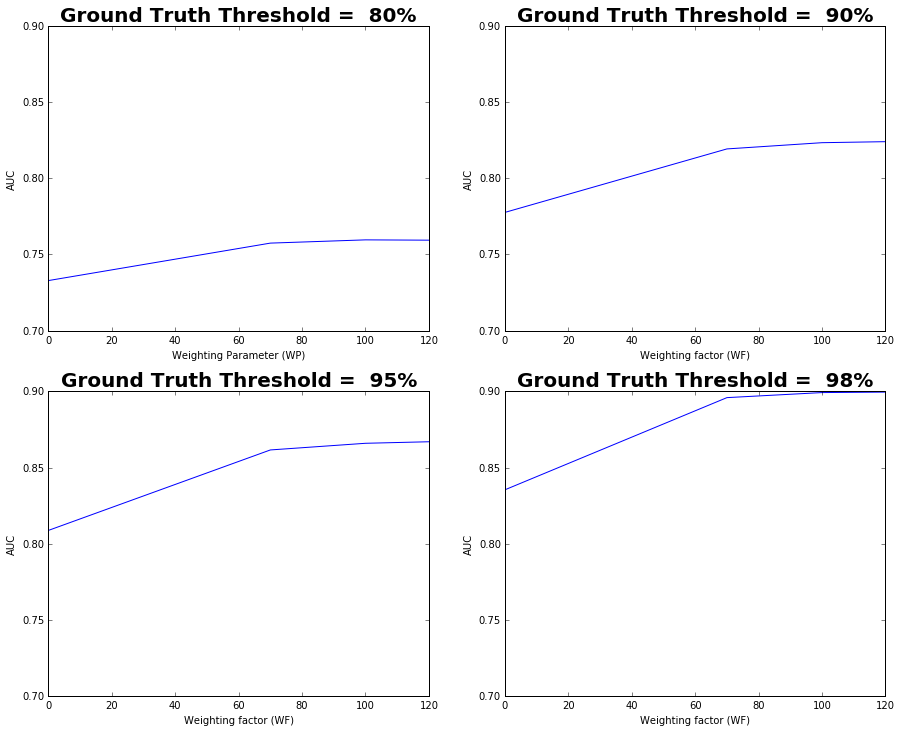

In [568]:
fig = plt.figure(figsize=(15,12))

subplot1 = fig.add_subplot(2,2,1)
subplot1.plot(weight_params, auc_results[0,:])
subplot1.set_title('Ground Truth Threshold =  80%', fontsize=20, fontweight='bold')
subplot1.set_ylim([0.7, 0.9])
subplot1.set_xlabel('Weighting Parameter (WP)')
subplot1.set_ylabel('AUC')

subplot1 = fig.add_subplot(2,2,2)
subplot1.plot(weight_params, auc_results[1,:])
subplot1.set_title('Ground Truth Threshold =  90%', fontsize=20, fontweight='bold')
subplot1.set_ylim([0.7, 0.9])
subplot1.set_xlabel('Weighting factor (WF)')
subplot1.set_ylabel('AUC')

subplot1 = fig.add_subplot(2,2,3)
subplot1.plot(weight_params, auc_results[2,:])
subplot1.set_title('Ground Truth Threshold =  95%', fontsize=20, fontweight='bold')
subplot1.set_ylim([0.7, 0.9])
subplot1.set_xlabel('Weighting factor (WF)')
subplot1.set_ylabel('AUC')

subplot1 = fig.add_subplot(2,2,4)
subplot1.plot(weight_params, auc_results[3,:])
subplot1.set_title('Ground Truth Threshold =  98%', fontsize=20, fontweight='bold')
subplot1.set_ylim([0.7, 0.9])
subplot1.set_xlabel('Weighting factor (WF)')
subplot1.set_ylabel('AUC')

# Linear weights


In [10]:
images_with_more_workers = get_ids_images_with_more_workers(ordered_fixations, 10)
print images_with_more_workers
print '\nNumber of images with 10 workers:',len(images_with_more_workers)

[285, 447, 455, 528, 549, 627, 680, 760, 873, 927, 955, 1032, 1068, 1301, 1368, 1541, 1580, 1598, 1599, 1673, 2036, 2178, 2283, 2301, 2304, 2310, 2444, 2545, 2749, 2982, 3282, 3293, 3406, 3514, 3764, 3888, 3967, 4072, 4295, 4438, 4526, 4532, 4615, 4658, 4737, 4841, 4969, 4990, 5184, 5236, 5308, 5454, 5470, 5507, 5521, 5628, 5634, 5822, 5883]

Number of images with 10 workers: 59


[[ 230.          143.            1.        ]
 [ 322.          127.            0.49494949]
 [ 393.          137.            0.        ]
 [ 237.          117.            0.        ]
 [  93.          162.            0.        ]]


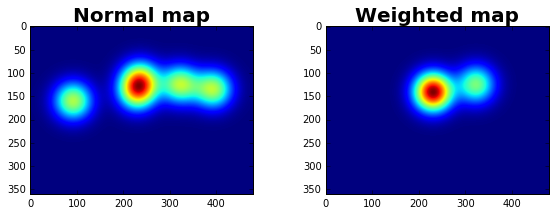

In [13]:
img_id = 900
w = 0
w_fix = ordered_fixations[img_id][0][w]
name, fixations, locations, timestamps, size = api.get_image_data(train, img_id)


fig = plt.figure(figsize=(15,3))


# Compute maps
prob_map = api.build_probability_map(w_fix, size, sigma=28)

w_fix_weighted = weighted_points(w_fix, -50)
print w_fix_weighted
w_prob_map = build_weighed_probability_map(w_fix_weighted, size, sigma=28)

# Show maps
subplot2 = fig.add_subplot(1,3,2)
subplot2.imshow(prob_map)
subplot2.set_title('Normal map', fontsize=20, fontweight='bold')

subplot3 = fig.add_subplot(1,3,3)
subplot3.imshow(w_prob_map)
subplot3.set_title('Weighted map', fontsize=20, fontweight='bold')


In [14]:
percentiles = [80, 90, 95, 98]
weight_params = [0, -17, -34, -52]

auc_results = np.zeros((len(percentiles), len(weight_params)))

for p in range(len(percentiles)):
    for w in range(len(weight_params)):
        percentile = percentiles[p]
        weight_param = weight_params[w]
        auc_results[p, w] = auc_for_images(images_with_more_workers, percentile, weight_param)
        
print auc_results

AUC with percentile 80, and weight_param 0 is : 
0.73285540302


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in divide


AUC with percentile 80, and weight_param -17 is : 
0.73905620615
AUC with percentile 80, and weight_param -34 is : 
0.732690874636
AUC with percentile 80, and weight_param -52 is : 
0.717376063863
AUC with percentile 90, and weight_param 0 is : 
0.777663483154
AUC with percentile 90, and weight_param -17 is : 
0.787189381264
AUC with percentile 90, and weight_param -34 is : 
0.775239580576
AUC with percentile 90, and weight_param -52 is : 
0.74929842085
AUC with percentile 95, and weight_param 0 is : 
0.808690920005
AUC with percentile 95, and weight_param -17 is : 
0.821058990023
AUC with percentile 95, and weight_param -34 is : 
0.798390959224
AUC with percentile 95, and weight_param -52 is : 
0.765785452319
AUC with percentile 98, and weight_param 0 is : 
0.835386987719
AUC with percentile 98, and weight_param -17 is : 
0.850265222192
AUC with percentile 98, and weight_param -34 is : 
0.810595510344
AUC with percentile 98, and weight_param -52 is : 
0.773027819889
[[ 0.7328554   0.7

In [15]:
auc_results

array([[ 0.7328554 ,  0.73905621,  0.73269087,  0.71737606],
       [ 0.77766348,  0.78718938,  0.77523958,  0.74929842],
       [ 0.80869092,  0.82105899,  0.79839096,  0.76578545],
       [ 0.83538699,  0.85026522,  0.81059551,  0.77302782]])

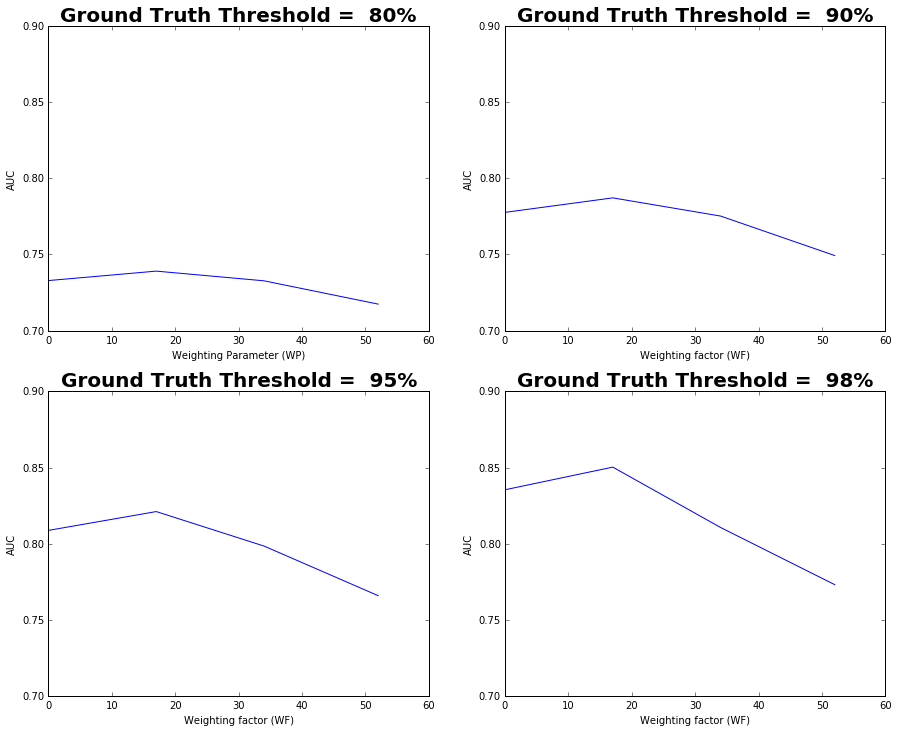

In [17]:
fig = plt.figure(figsize=(15,12))
y_lim = [0.7, 0.9]

weight_params = [0, 17, 34, 52]

subplot1 = fig.add_subplot(2,2,1)
subplot1.plot(weight_params, auc_results[0,:])
subplot1.set_title('Ground Truth Threshold =  80%', fontsize=20, fontweight='bold')
subplot1.set_ylim(y_lim)
subplot1.set_xlabel('Weighting Parameter (WP)')
subplot1.set_ylabel('AUC')

subplot1 = fig.add_subplot(2,2,2)
subplot1.plot(weight_params, auc_results[1,:])
subplot1.set_title('Ground Truth Threshold =  90%', fontsize=20, fontweight='bold')
subplot1.set_ylim(y_lim)
subplot1.set_xlabel('Weighting factor (WF)')
subplot1.set_ylabel('AUC')

subplot1 = fig.add_subplot(2,2,3)
subplot1.plot(weight_params, auc_results[2,:])
subplot1.set_title('Ground Truth Threshold =  95%', fontsize=20, fontweight='bold')
subplot1.set_ylim(y_lim)
subplot1.set_xlabel('Weighting factor (WF)')
subplot1.set_ylabel('AUC')

subplot1 = fig.add_subplot(2,2,4)
subplot1.plot(weight_params, auc_results[3,:])
subplot1.set_title('Ground Truth Threshold =  98%', fontsize=20, fontweight='bold')
subplot1.set_ylim(y_lim)
subplot1.set_xlabel('Weighting factor (WF)')
subplot1.set_ylabel('AUC')

# Exponentially up

In [42]:
images_with_more_workers = get_ids_images_with_more_workers(ordered_fixations, 12)
print images_with_more_workers
print '\nNumber of images with 10 workers:',len(images_with_more_workers)

[680, 927, 955, 1301, 1541, 4072, 4532, 5184, 5883]

Number of images with 10 workers: 9


[[  2.30000000e+02   1.43000000e+02   1.00000000e-01]
 [  3.22000000e+02   1.27000000e+02   2.06287816e-01]
 [  3.93000000e+02   1.37000000e+02   3.23872733e-01]
 [  2.37000000e+02   1.17000000e+02   4.53955493e-01]
 [  9.30000000e+01   1.62000000e+02   5.97864466e-01]]


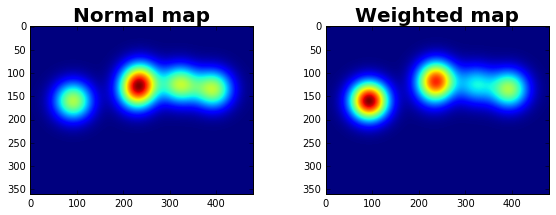

In [43]:
img_id = 900
w = 0
w_fix = ordered_fixations[img_id][0][w]
name, fixations, locations, timestamps, size = api.get_image_data(train, img_id)


fig = plt.figure(figsize=(15,3))


# Compute maps
prob_map = api.build_probability_map(w_fix, size, sigma=28)

w_fix_weighted = weighted_points(w_fix, 10)
print w_fix_weighted
w_prob_map = build_weighed_probability_map(w_fix_weighted, size, sigma=28)

# Show maps
subplot2 = fig.add_subplot(1,3,2)
subplot2.imshow(prob_map)
subplot2.set_title('Normal map', fontsize=20, fontweight='bold')

subplot3 = fig.add_subplot(1,3,3)
subplot3.imshow(w_prob_map)
subplot3.set_title('Weighted map', fontsize=20, fontweight='bold')


In [44]:
percentiles = [80, 90, 95, 98]
weight_params = [5, 10, 20, 50]

auc_results = np.zeros((len(percentiles), len(weight_params)))

for p in range(len(percentiles)):
    for w in range(len(weight_params)):
        percentile = percentiles[p]
        weight_param = weight_params[w]
        auc_results[p, w] = auc_for_images(images_with_more_workers, percentile, weight_param)
        
print auc_results

AUC with percentile 80, and weight_param 5 is : 
0.681254833113
AUC with percentile 80, and weight_param 10 is : 
0.676975590059
AUC with percentile 80, and weight_param 20 is : 
0.674502977549
AUC with percentile 80, and weight_param 50 is : 
0.670660809313
AUC with percentile 90, and weight_param 5 is : 
0.709015848621
AUC with percentile 90, and weight_param 10 is : 
0.703637879184
AUC with percentile 90, and weight_param 20 is : 
0.701828497847
AUC with percentile 90, and weight_param 50 is : 
0.698439084394
AUC with percentile 95, and weight_param 5 is : 
0.727211577914
AUC with percentile 95, and weight_param 10 is : 
0.720997854464
AUC with percentile 95, and weight_param 20 is : 
0.719084578529
AUC with percentile 95, and weight_param 50 is : 
0.715843827294
AUC with percentile 98, and weight_param 5 is : 
0.741601667483
AUC with percentile 98, and weight_param 10 is : 
0.733362624654
AUC with percentile 98, and weight_param 20 is : 
0.728265148123
AUC with percentile 98, and w

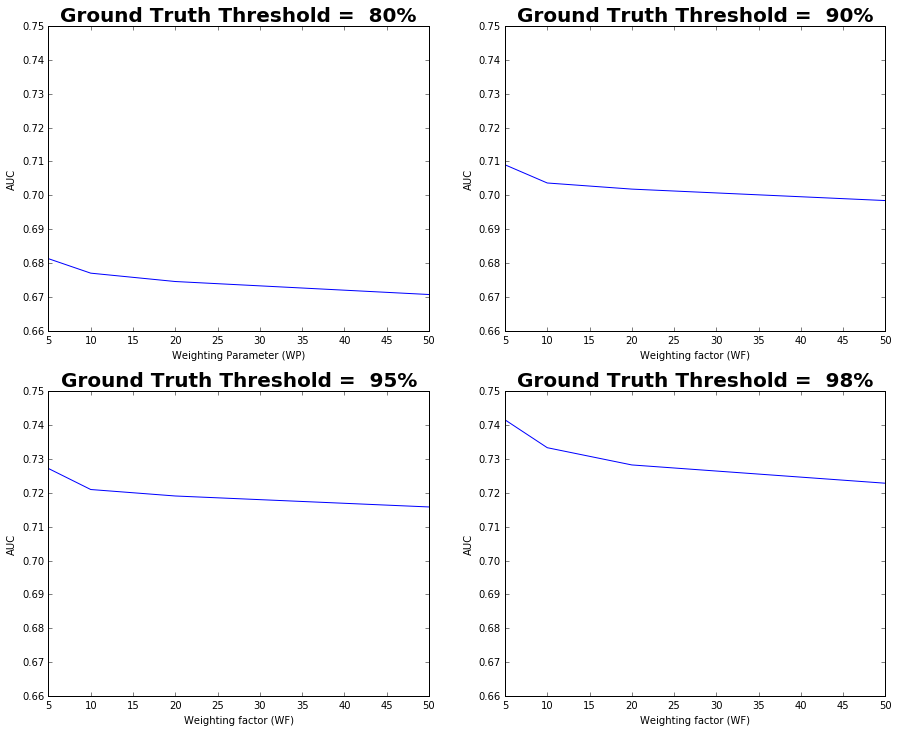

In [46]:
fig = plt.figure(figsize=(15,12))
y_lim = [.66, 0.75]

subplot1 = fig.add_subplot(2,2,1)
subplot1.plot(weight_params, auc_results[0,:])
subplot1.set_title('Ground Truth Threshold =  80%', fontsize=20, fontweight='bold')
subplot1.set_ylim(y_lim)
subplot1.set_xlabel('Weighting Parameter (WP)')
subplot1.set_ylabel('AUC')

subplot1 = fig.add_subplot(2,2,2)
subplot1.plot(weight_params, auc_results[1,:])
subplot1.set_title('Ground Truth Threshold =  90%', fontsize=20, fontweight='bold')
subplot1.set_ylim(y_lim)
subplot1.set_xlabel('Weighting factor (WF)')
subplot1.set_ylabel('AUC')

subplot1 = fig.add_subplot(2,2,3)
subplot1.plot(weight_params, auc_results[2,:])
subplot1.set_title('Ground Truth Threshold =  95%', fontsize=20, fontweight='bold')
subplot1.set_ylim(y_lim)
subplot1.set_xlabel('Weighting factor (WF)')
subplot1.set_ylabel('AUC')

subplot1 = fig.add_subplot(2,2,4)
subplot1.plot(weight_params, auc_results[3,:])
subplot1.set_title('Ground Truth Threshold =  98%', fontsize=20, fontweight='bold')
subplot1.set_ylim(y_lim)
subplot1.set_xlabel('Weighting factor (WF)')
subplot1.set_ylabel('AUC')

In [13]:
# Visualization of different weighting

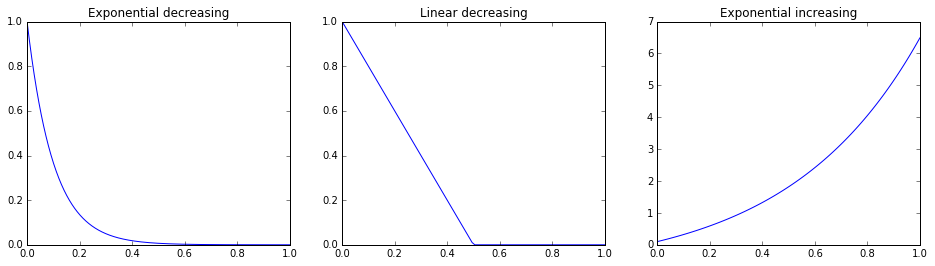

In [29]:
# Weighting function
from pylab import rcParams
rcParams['figure.figsize'] = 16, 4


plt.subplot(1,3,1)
x = np.linspace(0,1,1000)
weights = np.exp(-10* x)
plt.title('Exponential decreasing')
plt.plot(x,weights)

plt.subplot(1,3,2)
x = np.linspace(0,1,100)
params = -2
weights = np.maximum(params * x + 1, 0)
plt.title('Linear decreasing')
plt.plot(x,weights)

plt.subplot(1,3,3)
x = np.linspace(0,1,100)
params = 2
weights = np.exp(params* x)-0.9
plt.title('Exponential increasing')
plt.plot(x,weights)

(0.7, 1)

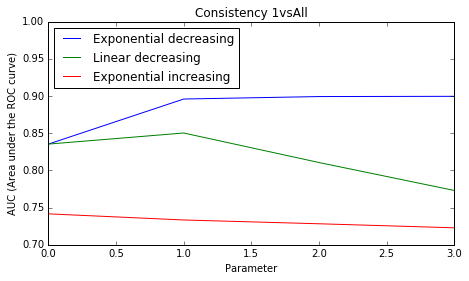

In [58]:
auc_exp_dec = [[ 0.7328554,   0.75746592,  0.7595979,   0.75939677],
[ 0.77766348,  0.8193608 ,  0.82345376,  0.8241214 ],
[ 0.80869092,  0.86155776,  0.86592726,  0.86693738],
[ 0.83538699,  0.89593354,  0.89925227,  0.89956568]]


auc_exp_inc = [[ 0.68125483,  0.67697559,  0.67450298,  0.67066081]
,[ 0.70901585,  0.70363788,  0.7018285,   0.69843908]
,[ 0.72721158 , 0.72099785  ,0.71908458  ,0.71584383]
,[ 0.74160167,  0.73336262  ,0.72826515  ,0.72285789]]

auc_lin_dec = [[ 0.7328554 ,  0.73905621,  0.73269087,  0.71737606],
[ 0.77766348,  0.78718938,  0.77523958,  0.74929842],
[ 0.80869092,  0.82105899,  0.79839096,  0.76578545],
[ 0.83538699,  0.85026522,  0.81059551,  0.77302782]]

plt.subplot(1,2,1)
plot_curve(auc_exp_dec, 'Exponential decreasing', title='Consistency 1vsAll')
plot_curve(auc_lin_dec, 'Linear decreasing')
plot_curve(auc_exp_inc, 'Exponential increasing')
plt.ylim([0.7, 1])

In [56]:
def plot_curve(train_history, metric_label, title=False,):
    loss = train_history[3]
    plt.plot(loss, label=metric_label)
    plt.xlabel('Parameter')
    plt.ylabel('AUC (Area under the ROC curve)')
    
    
    if title != False:
        plt.title(title)
        
    plt.legend(loc='upper left')
    return

